In [590]:
# %%
import sys
import os
sys.path.extend([r"E:\npongo Dropbox\benjamin clark\PythonProjects"])
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw
import numpy as np
import math as m
import pandas as pd
from scipy import stats
import itertools
import geopandas as gpd 
import PostDoc.db_clients.mssql_db_client as mssql  
import PostDoc.Plotting.squarify as squarify
import copy
import docx 
from docx.shared import Cm 
from PostDoc.Plotting.PlottingFunctions import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, scale_color_discrete, labs


chart_dir = r"E:\npongo Dropbox\benjamin clark\CIL\Products\EDF20240913\residue_burning"
if not os.path.exists(chart_dir):
       os.makedirs(chart_dir)

print('Python %s on %s' % (sys.version, sys.platform))
#load india national boundary as map background
india_sql = "SELECT geog.STAsBinary() as geog FROM [dbo].[national_boundaries]"
india = load_map_data(db_client, india_sql)
base_map = plot_map(None, india, None, 'base map', '')
base_map

# db_conn = {'server': '.\\npongo22', 'database': 'india_cost_of_cultivation_ghg_results_v1'}
# db_client = mssql.SqlServerClient(db_conn) 

db_conn_input = {'server': '.\\npongo22', 'database': 'india_agriculture_census_ghg_results_v1'}
db_client_input = mssql.SqlServerClient(db_conn_input)

Python 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)] on win32


In [591]:
farm_size_residue_burning_co2e_sql ="""
select *
from vwG_national_farm_size_residue_burning_co2e_summary 
"""
farm_size_residue_burning_co2e_df = load_table_data(db_client_input, farm_size_residue_burning_co2e_sql)
farm_size_residue_burning_co2e_df.head()

farm_size  gwp_time_period  mean_kg_co2e_kg_yield  \
0      LARGE (10 AND ABOVE)               20               0.017456   
1      LARGE (10 AND ABOVE)              100               0.008030   
2  SEMI-MEDIUM (2.0 - 3.99)              100               0.006961   
3  SEMI-MEDIUM (2.0 - 3.99)               20               0.015186   
4        SMALL (1.0 - 1.99)               20               0.014903   

   sd_kg_co2e_kg_yield  mean_kg_co2e_ha  sd_kg_co2e_ha  mean_total_t_co2e  \
0             0.027113        63.958547     255.810432       8.120531e+05   
1             0.012339        29.008745     113.624346       3.772732e+05   
2             0.011182        27.683701     101.823351       1.324106e+06   
3             0.024607        61.198490     229.046672       2.872632e+06   
4             0.024349        59.387340     223.896488       2.681423e+06   

   sd_total_t_co2e  
0     85181.379348  
1     38372.655411  
2     87575.824613  
3    195524.481261  
4    168114.010720

In [592]:
farm_size_residue_burning_co2e_df = farm_size_residue_burning_co2e_df.sort_values(by=['gwp_time_period', 'farm_size'], ascending=[True,True])
print(list(farm_size_residue_burning_co2e_df['farm_size']))
print({i:i for i in farm_size_residue_burning_co2e_df['farm_size']})   

['LARGE (10 AND ABOVE)', 'MARGINAL (BELOW 1.0)', 'MEDIUM (4.0 - 9.99)', 'SEMI-MEDIUM (2.0 - 3.99)', 'SMALL (1.0 - 1.99)', 'LARGE (10 AND ABOVE)', 'MARGINAL (BELOW 1.0)', 'MEDIUM (4.0 - 9.99)', 'SEMI-MEDIUM (2.0 - 3.99)', 'SMALL (1.0 - 1.99)']
{'LARGE (10 AND ABOVE)': 'LARGE (10 AND ABOVE)', 'MARGINAL (BELOW 1.0)': 'MARGINAL (BELOW 1.0)', 'MEDIUM (4.0 - 9.99)': 'MEDIUM (4.0 - 9.99)', 'SEMI-MEDIUM (2.0 - 3.99)': 'SEMI-MEDIUM (2.0 - 3.99)', 'SMALL (1.0 - 1.99)': 'SMALL (1.0 - 1.99)'}


In [593]:
farm_size_residue_burning_co2e_df['farm_size'] = pd.Categorical(farm_size_residue_burning_co2e_df['farm_size']
                                    , categories=['LARGE (10 AND ABOVE)', 'MEDIUM (4.0 - 9.99)', 'SEMI-MEDIUM (2.0 - 3.99)', 'SMALL (1.0 - 1.99)', 'MARGINAL (BELOW 1.0)'], ordered=True)
farm_size_residue_burning_co2e_df['farm_size'] = farm_size_residue_burning_co2e_df['farm_size'].cat.rename_categories({'LARGE (10 AND ABOVE)': '≥10 Ha', 
                                                                                               'MEDIUM (4.0 - 9.99)': '4.0 - 9.99 Ha', 
                                                                                               'SEMI-MEDIUM (2.0 - 3.99)': '2.0 - 3.99 Ha', 
                                                                                               'SMALL (1.0 - 1.99)': '1.0 - 1.99 Ha', 
                                                                                               'MARGINAL (BELOW 1.0)': '<1.0 Ha'})

farm_size_residue_burning_co2e_df['mean_kg_co2e_ha_min'] = farm_size_residue_burning_co2e_df.apply(
    lambda row: 0 if row['mean_kg_co2e_ha'] - row['sd_kg_co2e_ha'] < 0 else row['mean_kg_co2e_ha'] - row['sd_kg_co2e_ha'],
    axis=1
)

gwp_label={20:'$GWP_{20}$', 100:'$GWP_{100}$'}
farm_size_residue_burning_co2e_df['gwp_label'] = farm_size_residue_burning_co2e_df['gwp_time_period'].map(gwp_label)

farm_size_residue_burning_co2e_df['gwp_label'] = pd.Categorical(farm_size_residue_burning_co2e_df['gwp_label']
                                    , categories=list(farm_size_residue_burning_co2e_df['gwp_label'].unique()), ordered=True)
farm_size_residue_burning_co2e_df.head()

farm_size  gwp_time_period  mean_kg_co2e_kg_yield  sd_kg_co2e_kg_yield  \
0         ≥10 Ha               20               0.017456             0.027113   
5        <1.0 Ha               20               0.014759             0.024038   
8  4.0 - 9.99 Ha               20               0.016046             0.026163   
3  2.0 - 3.99 Ha               20               0.015186             0.024607   
4  1.0 - 1.99 Ha               20               0.014903             0.024349   

   mean_kg_co2e_ha  sd_kg_co2e_ha  mean_total_t_co2e  sd_total_t_co2e  \
0        63.958547     255.810432       8.120531e+05     85181.379348   
5        59.495842     206.891396       2.601512e+06    174086.007153   
8        61.616695     229.900117       2.521756e+06    191419.008454   
3        61.198490     229.046672       2.872632e+06    195524.481261   
4        59.387340     223.896488       2.681423e+06    168114.010720   

   mean_kg_co2e_ha_min   gwp_label  
0                    0  $GWP_{20}$  
5                    0  $GWP_{20}$  
8                    0  $GWP_{20}$  
3                    0  $GWP_{20}$  
4                    0  $GWP_{20}$

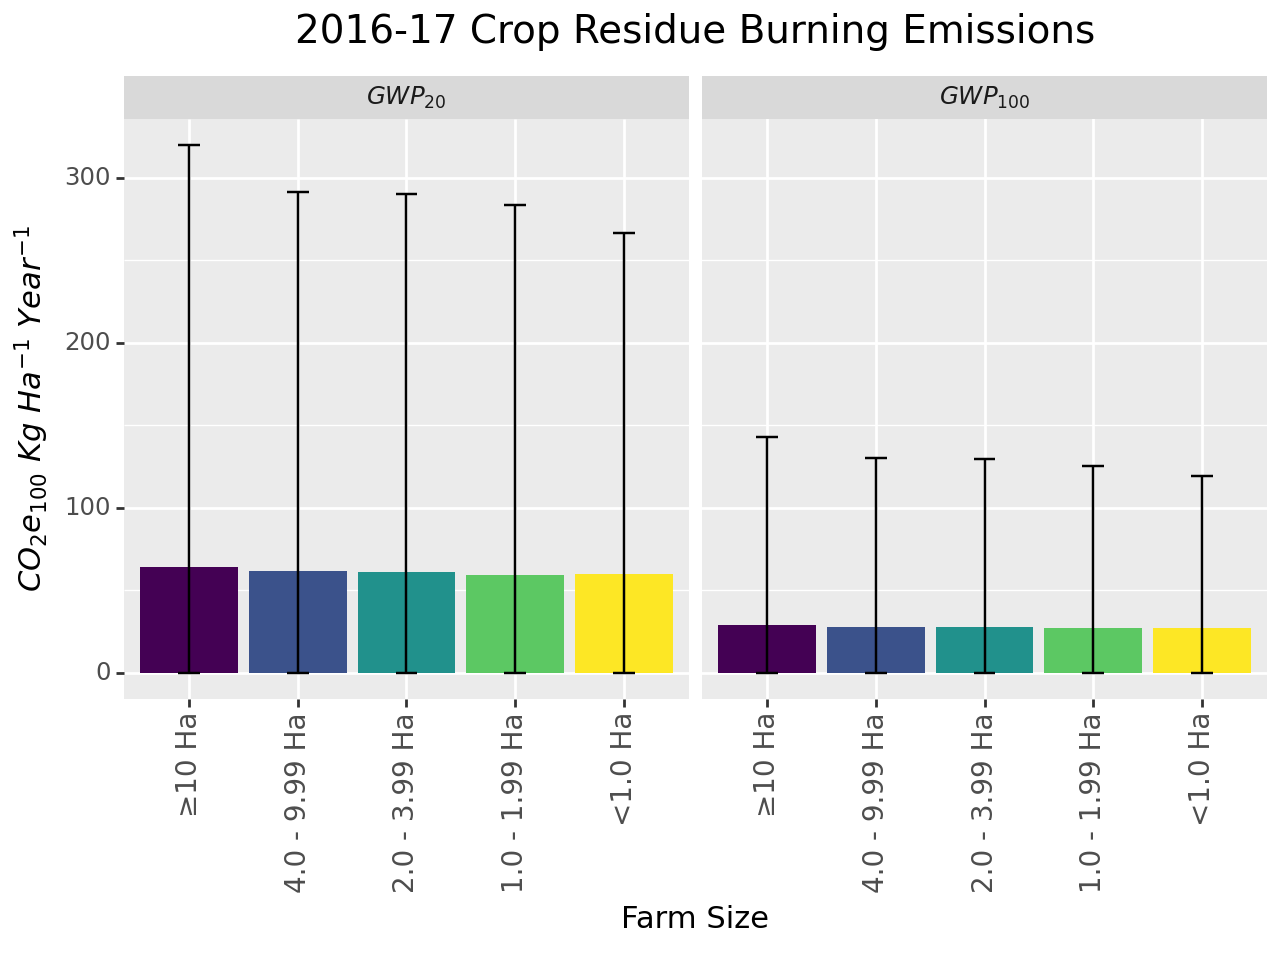

In [594]:
p = (ggplot()
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_col(farm_size_residue_burning_co2e_df,aes(x='farm_size', y='mean_kg_co2e_ha',fill='farm_size'))
            + geom_errorbar(farm_size_residue_burning_co2e_df, aes(x='farm_size', ymin='mean_kg_co2e_ha_min', ymax='mean_kg_co2e_ha + sd_kg_co2e_ha'), width=0.2)
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Crop Residue Burning Emissions', x="Farm Size", y="$CO_2e_{100}\ Kg\ Ha^{-1}\ Year^{-1}$")
            # + scale_y_log10()
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=90, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
             + facet_wrap('~gwp_label')
            )
print(p)
p.save(filename=f"national_farm_size_residue_burning_mean_kg_co2e_ha_14x25.png", path=chart_dir,height=14, width=25, units='cm', dpi=92)
p.save(filename=f"national_farm_size_residue_burning_mean_kg_co2e_ha_14x12.png", path=chart_dir,height=14, width=12, units='cm', dpi=92)

In [595]:
# farm_size_residue_burning_co2e_df = farm_size_residue_burning_co2e_df.sort_values(by=[ 'mean_kg_co2e_kg_yield'], ascending=[True])
# farm_size_residue_burning_co2e_df['farm_size'] = pd.Categorical(farm_size_residue_burning_co2e_df['farm_size']
#                                     , categories=list(farm_size_residue_burning_co2e_df['farm_size'].unique())
# , ordered=True)

farm_size_residue_burning_co2e_df['mean_kg_co2e_kg_yield_min'] = farm_size_residue_burning_co2e_df.apply(
    lambda row: 0 if row['mean_kg_co2e_kg_yield'] - row['sd_kg_co2e_kg_yield'] < 0 else row['mean_kg_co2e_kg_yield'] - row['sd_kg_co2e_kg_yield'],
    axis=1
)

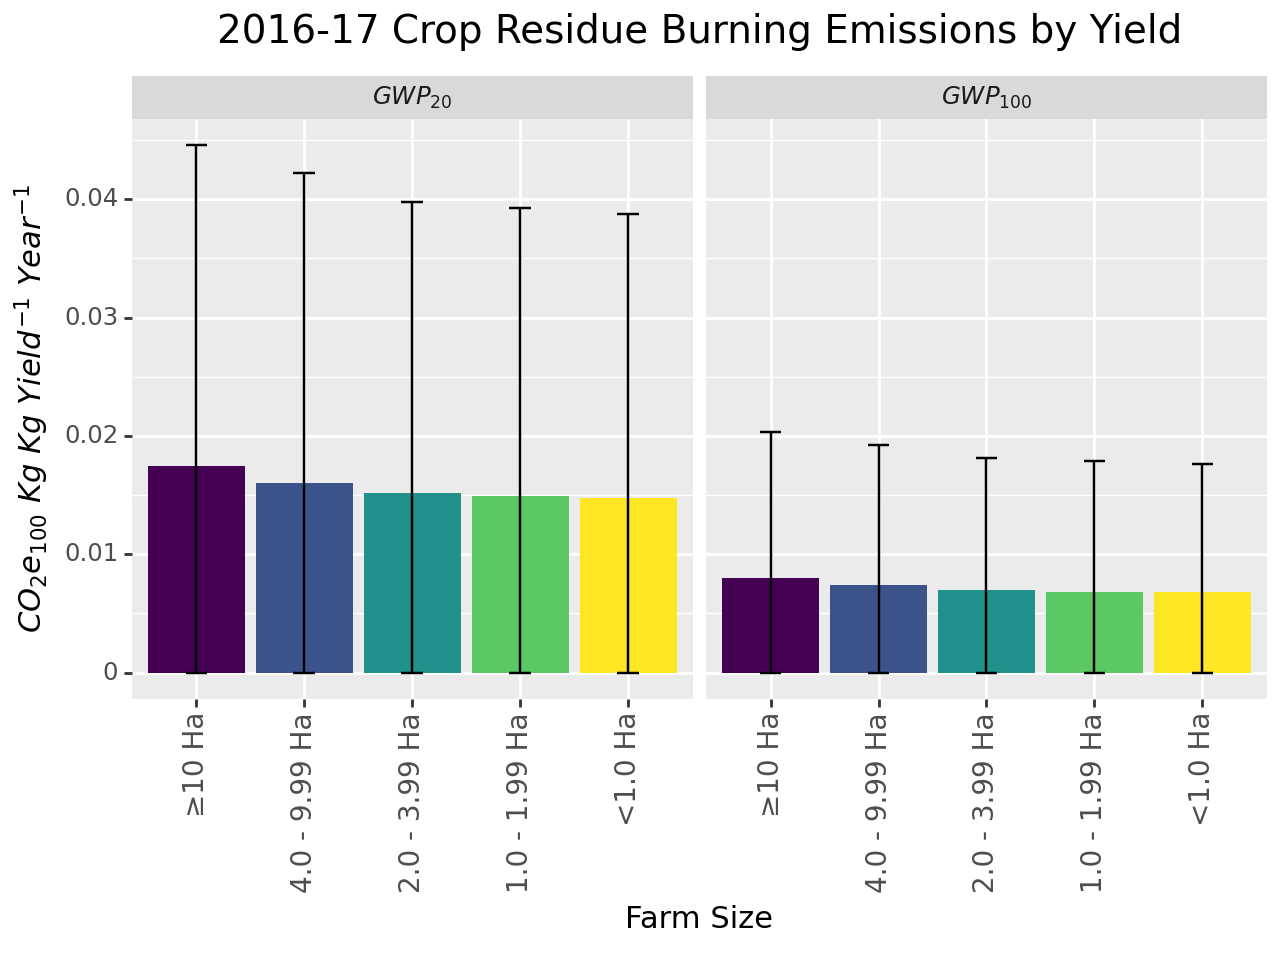

In [596]:
p = (ggplot()
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_col(farm_size_residue_burning_co2e_df,aes(x='farm_size', y='mean_kg_co2e_kg_yield',fill='farm_size'))
            + geom_errorbar(farm_size_residue_burning_co2e_df, aes(x='farm_size', ymin='mean_kg_co2e_kg_yield_min', ymax='mean_kg_co2e_kg_yield + sd_kg_co2e_kg_yield'), width=0.2)
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Crop Residue Burning Emissions by Yield', x="Farm Size", y="$CO_2e_{100}\ Kg\ Kg\ Yield^{-1}\ Year^{-1}$")
            # + scale_y_log10()
            + guides(fill=None) 
            + theme(axis_text_x=element_text(angle=90, va="top", ha="center", size=10), plot_title=element_text(ha='center', size=14))
             + facet_wrap('~gwp_label')
            )
print(p)
p.save(filename=f"national_farm_size_mean_kg_co2e_kg_yield_14x25.png", path=chart_dir,height=14, width=25, units='cm', dpi=92)

In [597]:
# farm_size_residue_burning_co2e_df = farm_size_residue_burning_co2e_df.sort_values(by=[ 'mean_total_t_co2e'], ascending=[True])
# farm_size_residue_burning_co2e_df['farm_size'] = pd.Categorical(farm_size_residue_burning_co2e_df['farm_size']
#                                     , categories=list(farm_size_residue_burning_co2e_df['farm_size'].unique())
# , ordered=True)

farm_size_residue_burning_co2e_df['mean_total_t_co2e_min'] = farm_size_residue_burning_co2e_df.apply(
    lambda row: 0 if row['mean_total_t_co2e'] - row['sd_total_t_co2e'] < 0 else row['mean_total_t_co2e'] - row['sd_total_t_co2e'],
    axis=1
)

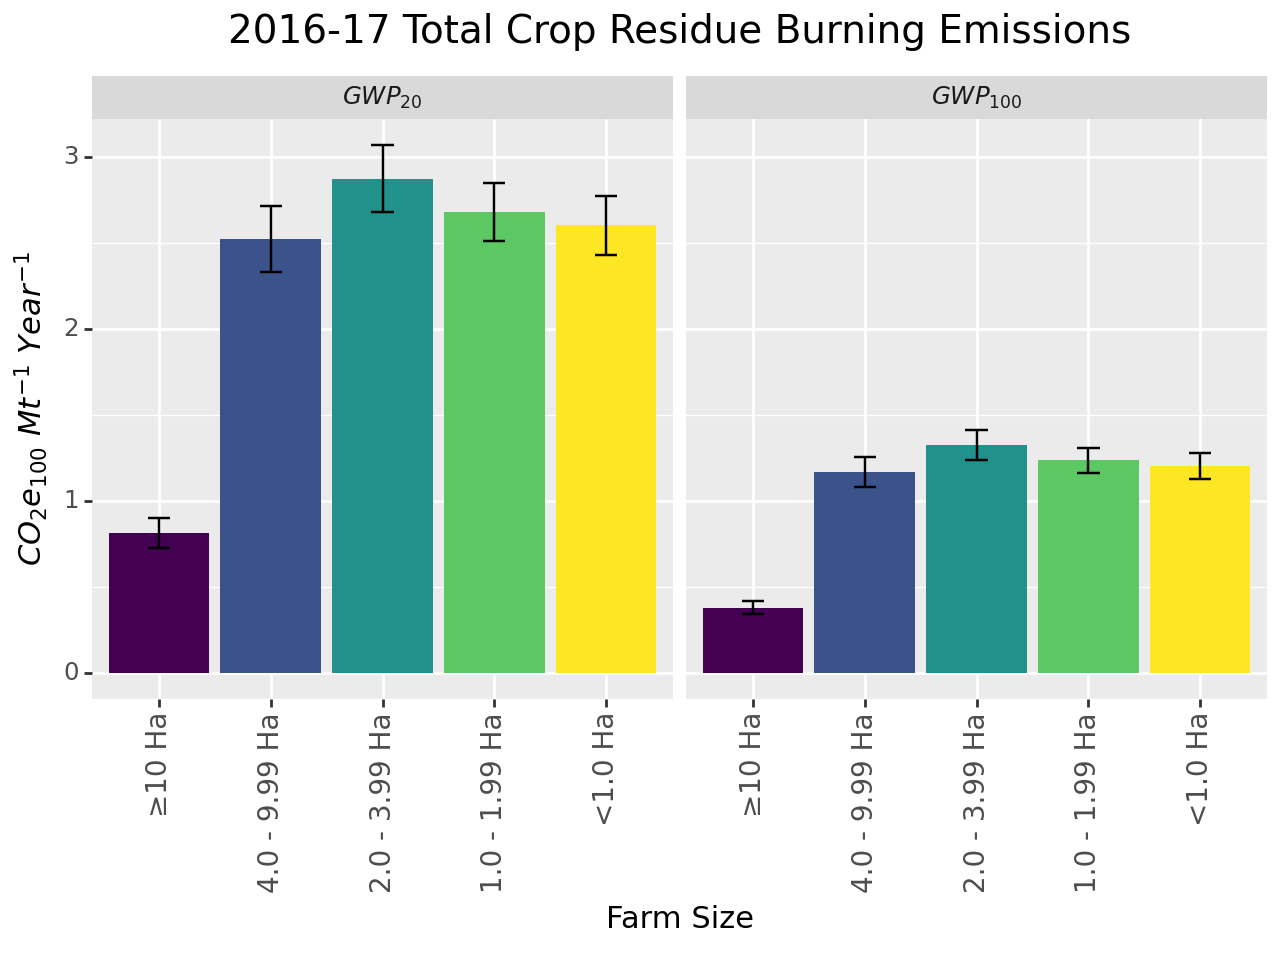

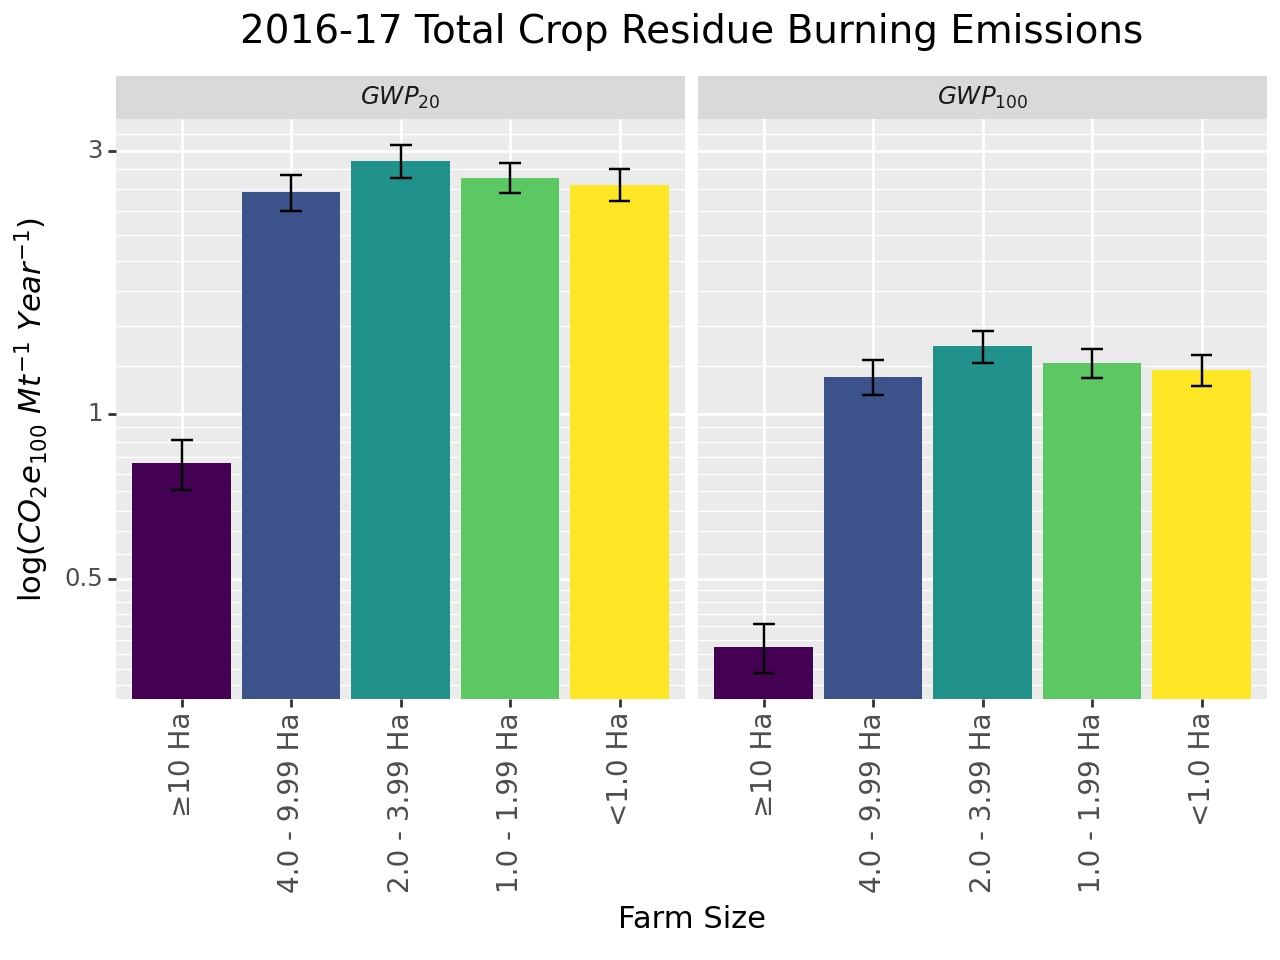

In [598]:
p = (ggplot()
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_col(farm_size_residue_burning_co2e_df,aes(x='farm_size', y='mean_total_t_co2e/1000000',fill='farm_size'))
            + geom_errorbar(farm_size_residue_burning_co2e_df, aes(x='farm_size', ymin='mean_total_t_co2e_min/1000000', ymax='mean_total_t_co2e/1000000 + sd_total_t_co2e/1000000'), width=0.2)
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Total Crop Residue Burning Emissions', x="Farm Size", y="$CO_2e_{100}\ Mt^{-1}\ Year^{-1}$")
            #+ scale_y_log10()
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=90, va="top", ha="center", size=10),plot_title=element_text(ha='center', size=14))
             + facet_wrap('~gwp_label')
            )
print(p)
p.save(filename=f"national_farm_size_residue_farm_size_mean_total_t_co2e_14x25.png", path=chart_dir,height=14, width=25, units='cm', dpi=92)
p.save(filename=f"national_farm_size_residue_farm_size_mean_total_t_co2e_14x12.png", path=chart_dir,height=14, width=12, units='cm', dpi=92)

g = (p  + labs(title='2016-17 Total Crop Residue Burning Emissions', x="Farm Size", y="log($CO_2e_{100}\ Mt^{-1}\ Year^{-1}$)")
            + scale_y_log10())

g.save(filename=f"national_farm_size_farm_size_residue_mean_total_t_co2e_log_14x25.png", path=chart_dir,height=14, width=25, units='cm', dpi=92)
g.save(filename=f"national_farm_size_farm_size_residue_mean_total_t_co2e_log_14x12.png", path=chart_dir,height=14, width=12, units='cm', dpi=92)

print(g)

In [599]:
import numpy as np
import math as m
import pandas as pd
from scipy import stats
import itertools
import geopandas as gpd 
import PostDoc.db_clients.mssql_db_client as mssql  
import PostDoc.Plotting.squarify as squarify
import copy
import docx 
from docx.shared import Cm 
from PostDoc.Plotting.PlottingFunctions import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, scale_color_discrete, labs


chart_dir = r"E:\npongo Dropbox\benjamin clark\CIL\Products\EDF20240913"
if not os.path.exists(chart_dir):
       os.makedirs(chart_dir)

print('Python %s on %s' % (sys.version, sys.platform))
#load india national boundary as map background
india_sql = "SELECT geog.STAsBinary() as geog FROM [dbo].[national_boundaries]"
india = load_map_data(db_client, india_sql)
base_map = plot_map(None, india, None, 'base map', '')
base_map

state_sql = "select * from vwM_india_states option(maxrecursion 0)"
india_states = load_map_data(db_client, state_sql)



# db_conn = {'server': '.\\npongo22', 'database': 'india_cost_of_cultivation_ghg_results_v1'}
# db_client = mssql.SqlServerClient(db_conn) 

db_conn_input = {'server': '.\\npongo22', 'database': 'india_agriculture_census_ghg_results_v1'}
db_client_input = mssql.SqlServerClient(db_conn_input)

Python 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)] on win32


In [600]:
district_sql = """select * from district_boundaries"""
district_df = load_map_data(db_client, district_sql)
district_df.head()

GEOSException: ParseException: Unknown WKB type 16

In [601]:
district_sql = """select district_name, geog.STAsBinary() as geog from district_boundaries"""
district_df = load_map_data(db_client, district_sql)
district_df.head()

district_name                                               geog  \
0      North West  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00o\x00\x0...   
1      South West  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00-\x01\x0...   
2       Karimganj  b'\x01\x03\x00\x00\x00\x01\x00\x00\x001\x01\x0...   
3  Uttara Kannada  b'\x01\x06\x00\x00\x00\x0e\x00\x00\x00\x01\x03...   
4         Rajgarh  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd8\x02...   

                                            geometry  
0  POLYGON ((77.08612 28.87932, 77.08041 28.87480...  
1  POLYGON ((76.93955 28.66928, 76.93292 28.66408...  
2  POLYGON ((92.30766 24.91625, 92.30320 24.91597...  
3  MULTIPOLYGON (((74.48325 14.01546, 74.48078 14...  
4  POLYGON ((76.33018 24.24932, 76.32114 24.24683...

In [602]:
p =  plot_map(None, district_df, None, 'base map', '')

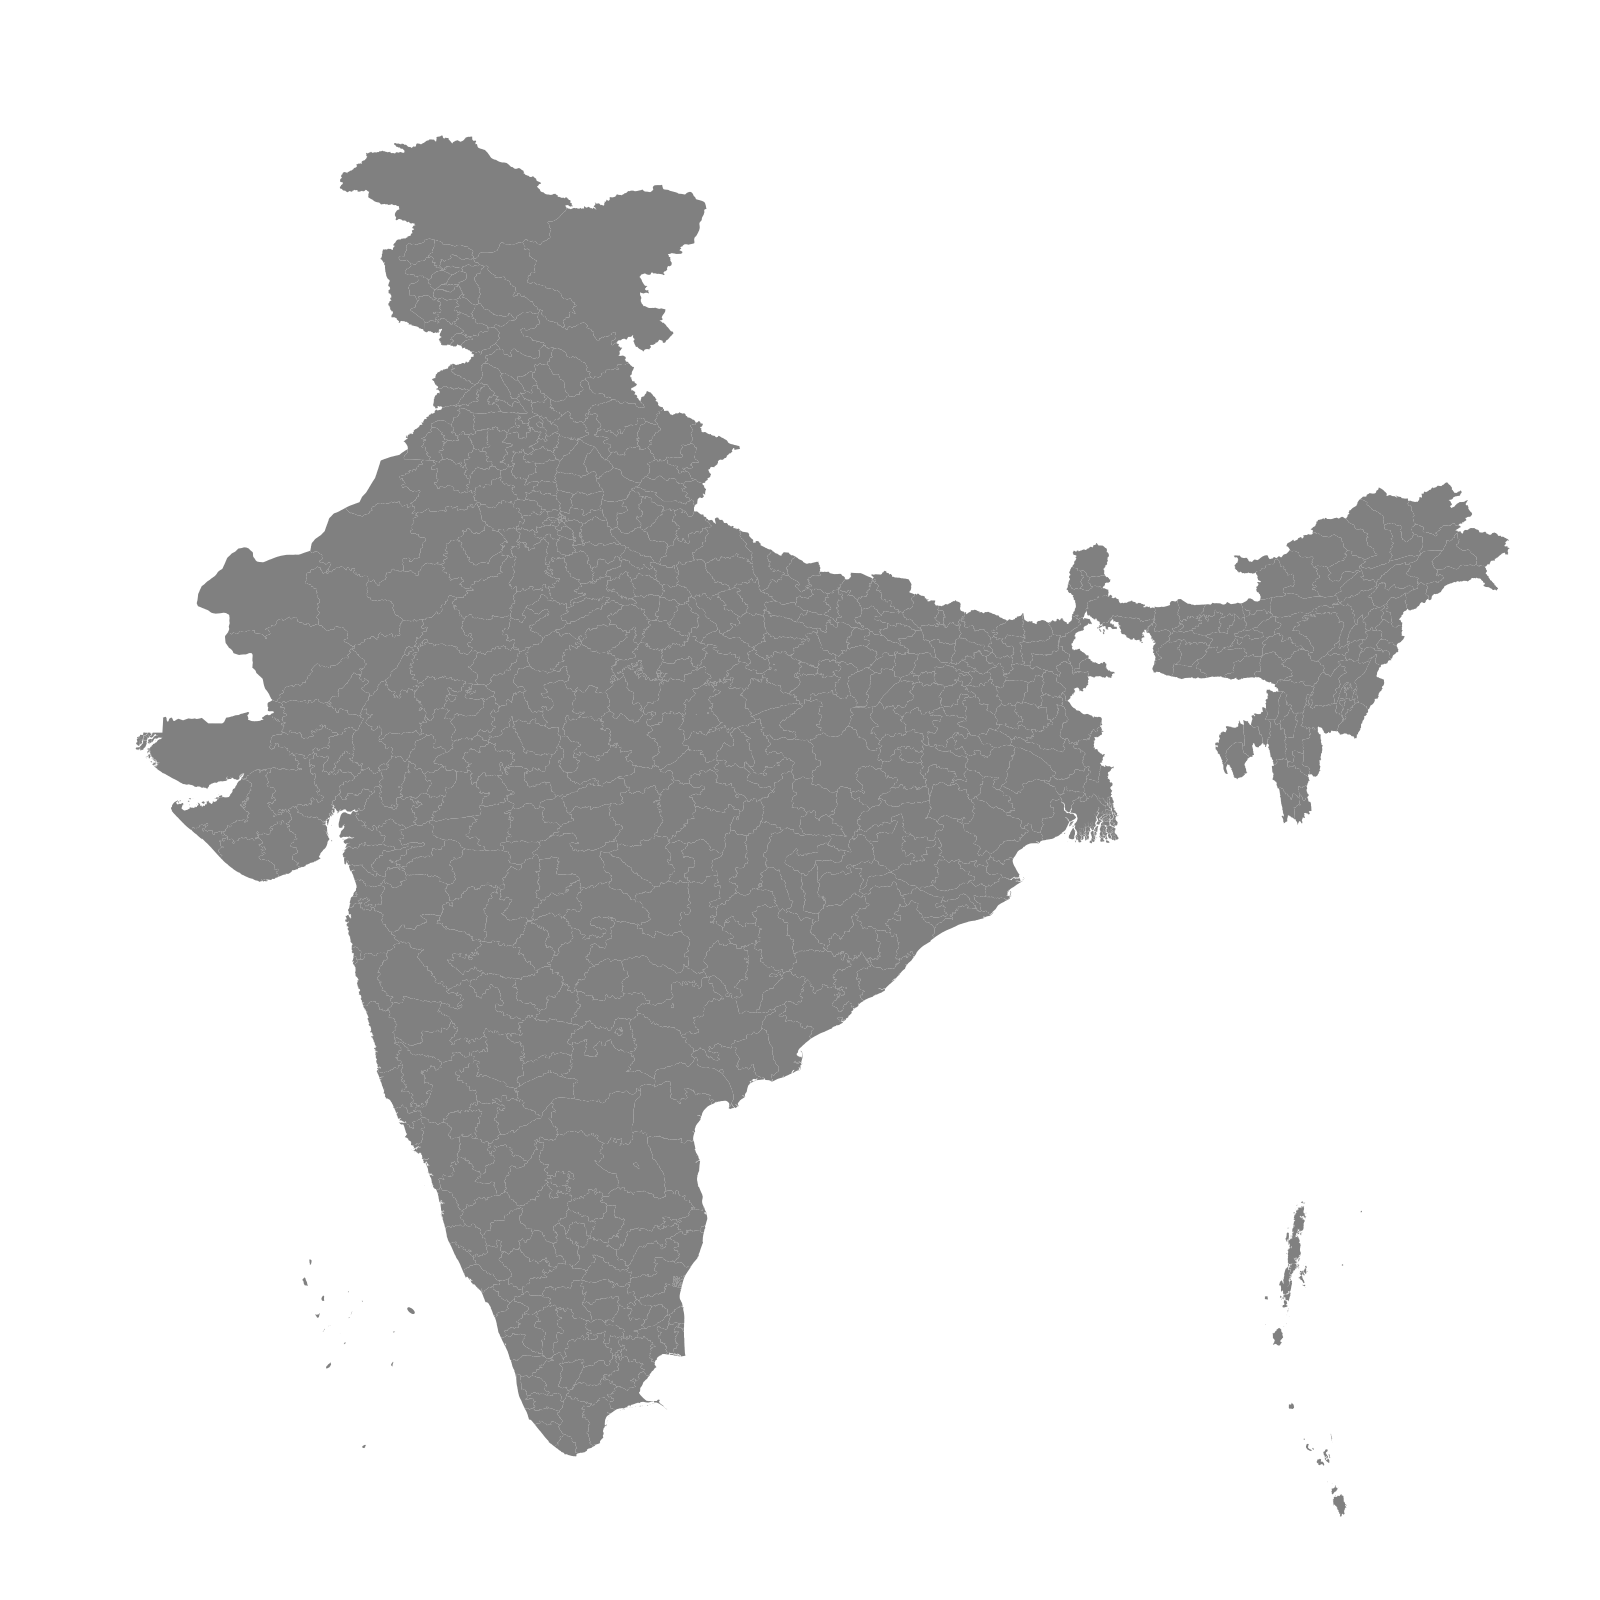

<Figure Size: (800 x 800)>

In [603]:
p =  plot_map(None, district_df, None, 'base map', '')
p

In [604]:
district_climate_sql = """select  geog.STAsBinary() as geog from district_climate"""
district_climate_df = load_map_data(db_client, district_climate_sql)
district_climate_df.head()

(208, b"Invalid object name 'district_climate'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n") <class 'pymssql._pymssql.ProgrammingError'> mssql_db_client.py 178


ProgrammingError: (208, b"Invalid object name 'district_climate'.DB-Lib error message 20018, severity 16:\nGeneral SQL Server error: Check messages from the SQL Server\n")

In [605]:
district_sql = """select district_name, geog.STAsBinary() as geog from district_boundaries"""
district_df = load_map_data(db_client_input, district_sql)
district_df.head()

district_name                                               geog  \
0      North West  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00o\x00\x0...   
1      South West  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00-\x01\x0...   
2       Karimganj  b'\x01\x03\x00\x00\x00\x01\x00\x00\x001\x01\x0...   
3  Uttara Kannada  b'\x01\x06\x00\x00\x00\x0e\x00\x00\x00\x01\x03...   
4         Rajgarh  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd8\x02...   

                                            geometry  
0  POLYGON ((77.08612 28.87932, 77.08041 28.87480...  
1  POLYGON ((76.93955 28.66928, 76.93292 28.66408...  
2  POLYGON ((92.30766 24.91625, 92.30320 24.91597...  
3  MULTIPOLYGON (((74.48325 14.01546, 74.48078 14...  
4  POLYGON ((76.33018 24.24932, 76.32114 24.24683...

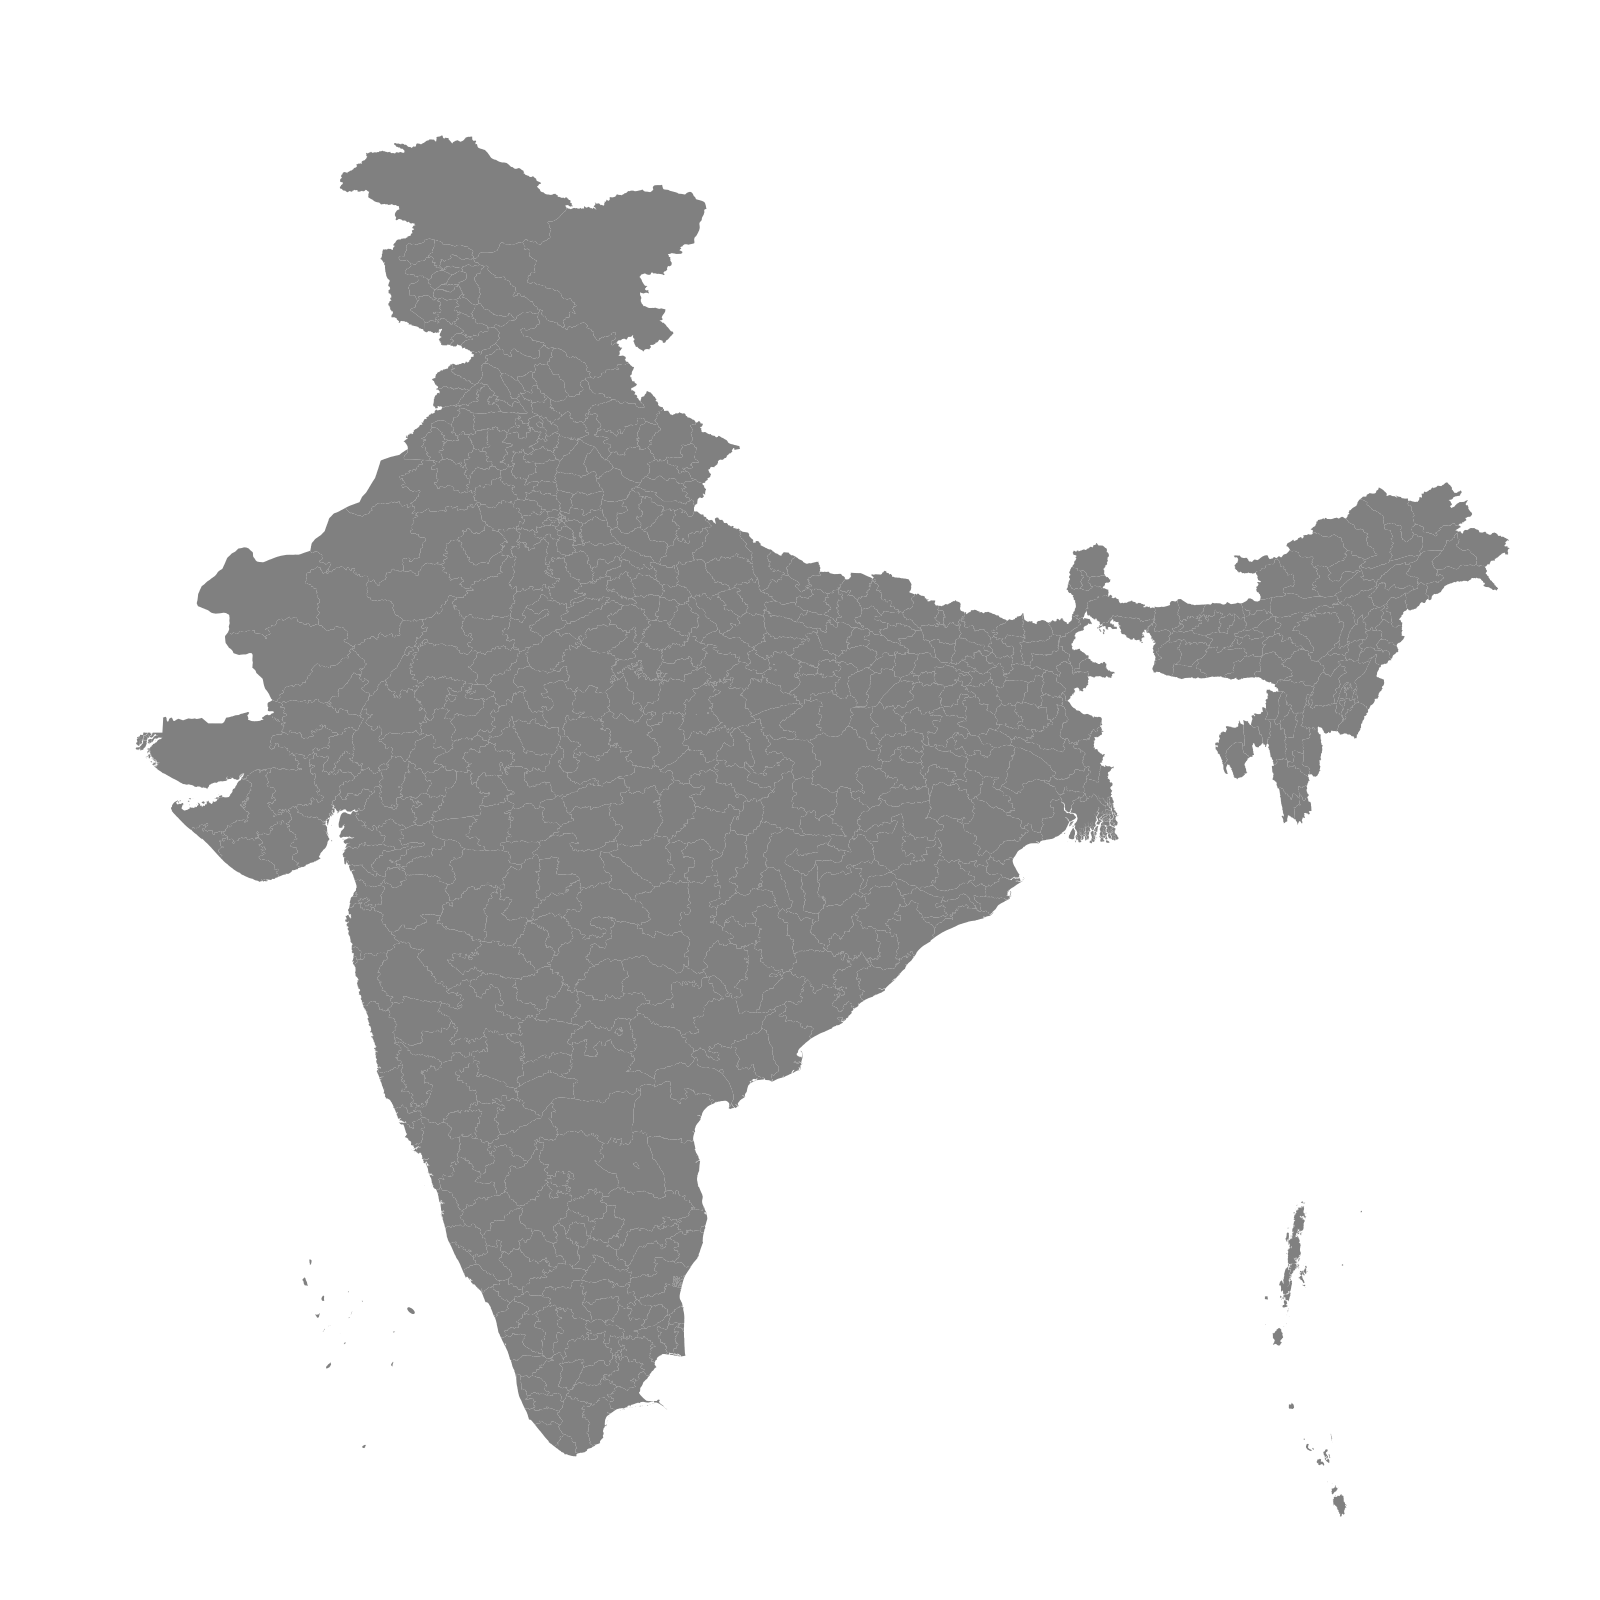

<Figure Size: (800 x 800)>

In [606]:
p =  plot_map(None, district_df, None, 'base map', '')
p

In [607]:
district_climate_sql = """select  geog.STAsBinary() as geog from district_climate"""
district_climate_df = load_map_data(db_client_input, district_climate_sql)
district_climate_df.head()

geog  \
0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00o\x00\x0...   
1  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00-\x01\x0...   
2  b'\x01\x02\x00\x00\x00\x10\x00\x00\x00ct\xe5X\...   
3  b'\x01\x03\x00\x00\x00\x01\x00\x00\x001\x01\x0...   
4  b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...   

                                            geometry  
0  POLYGON ((77.08612 28.87932, 77.08041 28.87480...  
1  POLYGON ((76.93955 28.66928, 76.93292 28.66408...  
2  LINESTRING (92.42208 24.25108, 92.41618 24.251...  
3  POLYGON ((92.30766 24.91625, 92.30320 24.91597...  
4  MULTIPOLYGON (((74.97695 14.52362, 74.97671 14...

In [608]:
p =  plot_map(None, district_climate_df, None, 'base map', '')

In [609]:
p =  plot_map(None, district_climate_df, None, 'base map', '')
p

AttributeError: 'LineString' object has no attribute 'geoms'

In [610]:
district_climate_sql = """select  geog.STAsBinary() as geog from district_climate_temp"""
district_climate_df = load_map_data(db_client_input, district_climate_sql)
district_climate_df.head()

geog  \
0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00o\x00\x0...   
1  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00-\x01\x0...   
2  b'\x01\x03\x00\x00\x00\x01\x00\x00\x001\x01\x0...   
3  b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0f\x00...   
4  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x02\x01...   

                                            geometry  
0  POLYGON ((77.08612 28.87932, 77.08041 28.87480...  
1  POLYGON ((76.93955 28.66928, 76.93292 28.66408...  
2  POLYGON ((92.30766 24.91625, 92.30320 24.91597...  
3  POLYGON ((74.97695 14.52362, 74.97671 14.52142...  
4  POLYGON ((74.28519 15.52509, 74.27732 15.52174...

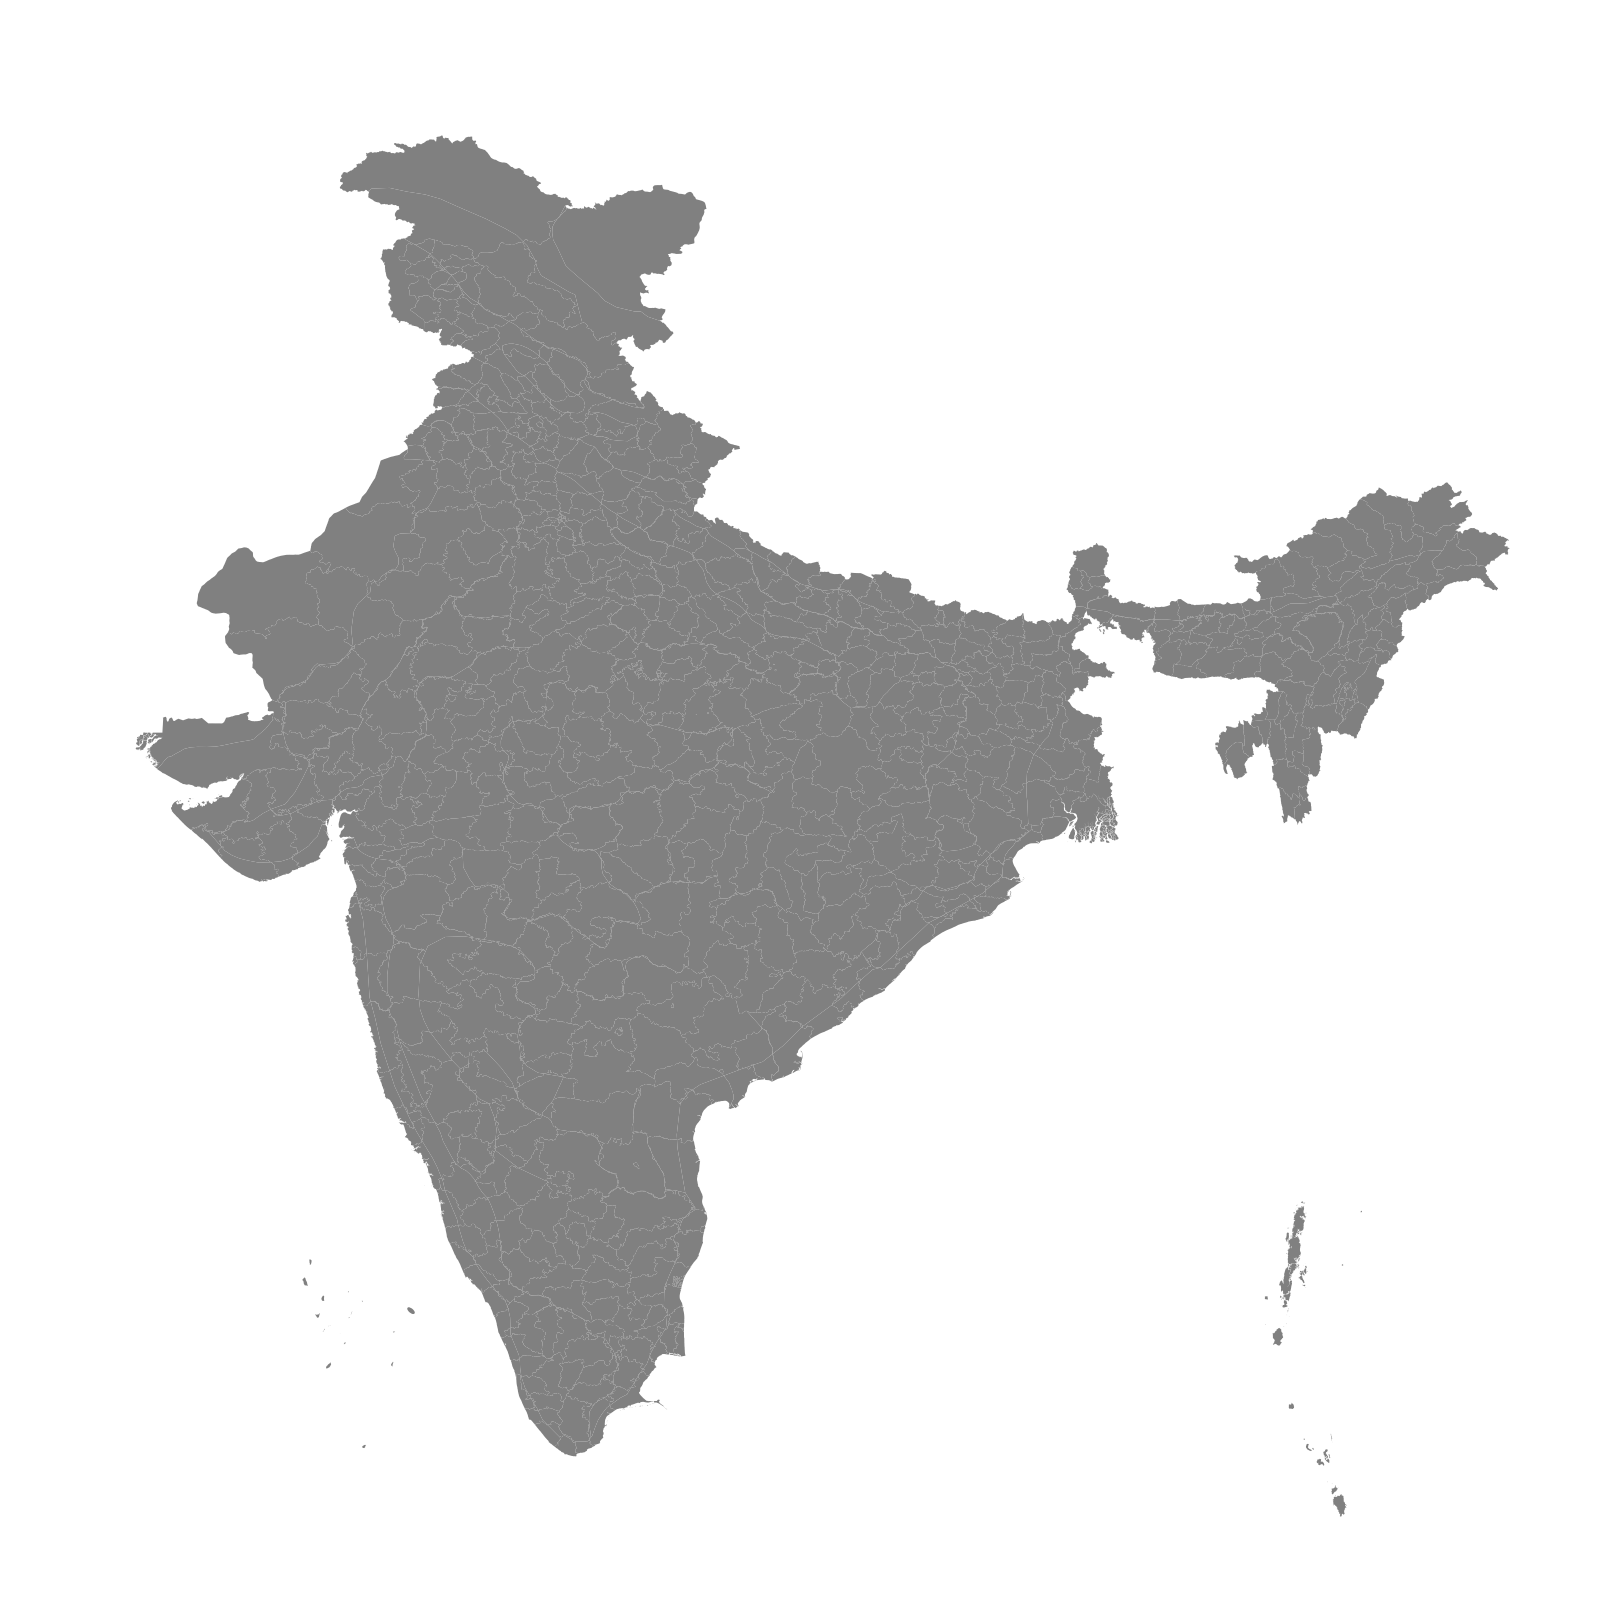

<Figure Size: (800 x 800)>

In [611]:
p =  plot_map(None, district_climate_df, None, 'base map', '')
p

In [612]:
district_climate_sql = """select  geog.STAsBinary() as geog from district_climate_temp"""
district_climate_df = load_map_data(db_client_input, district_climate_sql)
district_climate_df.head()

geog  \
0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00o\x00\x0...   
1  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00-\x01\x0...   
2  b'\x01\x03\x00\x00\x00\x01\x00\x00\x001\x01\x0...   
3  b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0f\x00...   
4  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x02\x01...   

                                            geometry  
0  POLYGON ((77.08612 28.87932, 77.08041 28.87480...  
1  POLYGON ((76.93955 28.66928, 76.93292 28.66408...  
2  POLYGON ((92.30766 24.91625, 92.30320 24.91597...  
3  POLYGON ((74.97695 14.52362, 74.97671 14.52142...  
4  POLYGON ((74.28519 15.52509, 74.27732 15.52174...

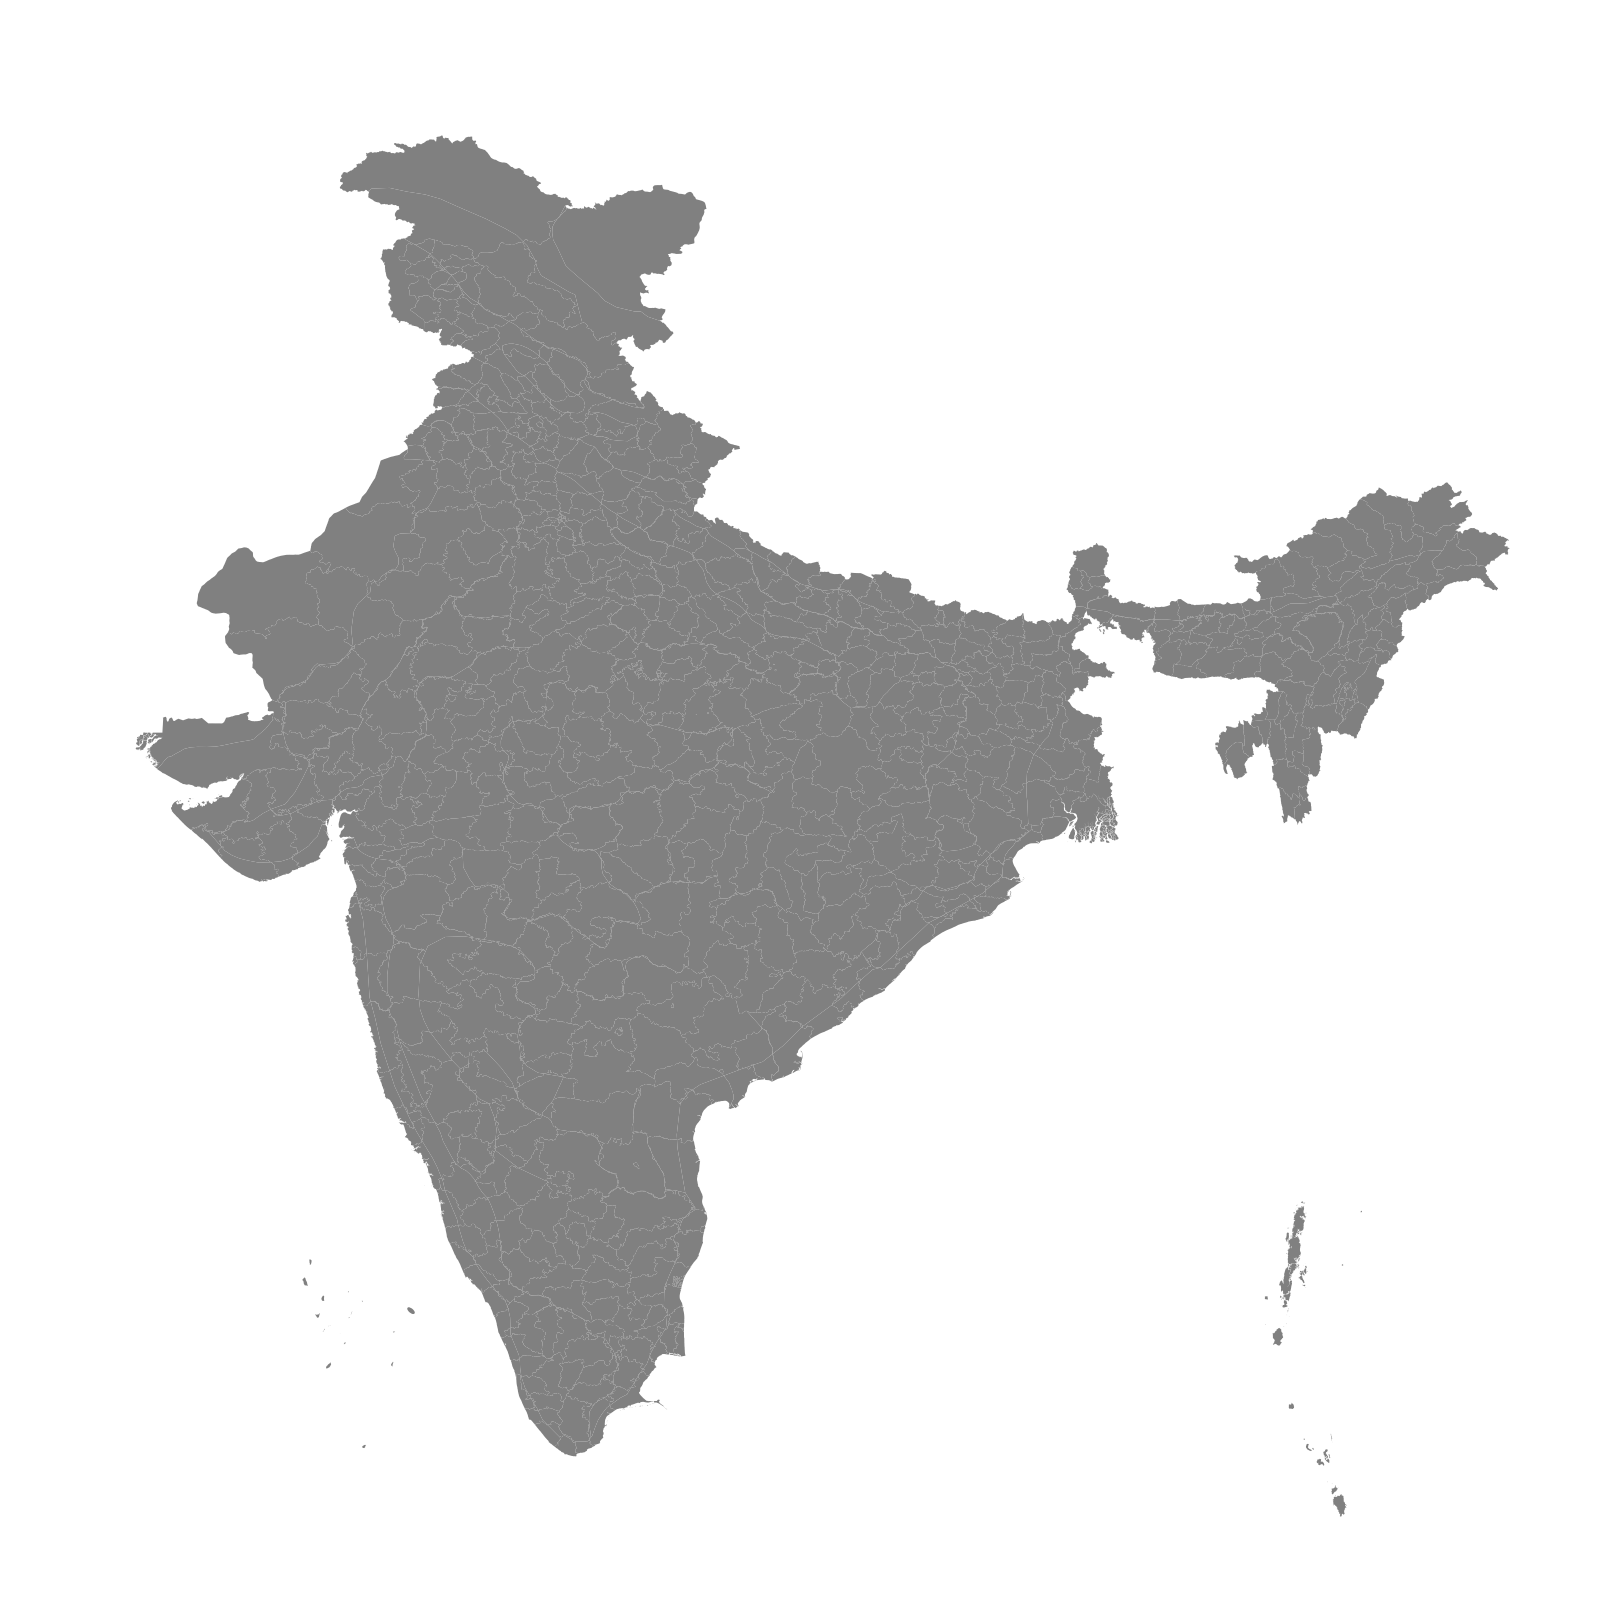

<Figure Size: (800 x 800)>

In [613]:
p =  plot_map(None, district_climate_df, None, 'base map', '')
p

In [614]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  geog_checksum apy_crop          crop  \
0 -1106456938604680692    -2140838676     Rice  KHARIF PADDY   
1  2486562343091493142    -2140838676     Rice         PADDY   
2   144395927502297411    -2140838676     Rice         PADDY   
3  8282482022152717920    -2140838676     Rice  KHARIF PADDY   
4  -209892897293663254    -2140838676     Rice  KHARIF PADDY   

              farm_size irrigated  adj_crop_area  adj_fert_area  \
0  MARGINAL (BELOW 1.0)         I     947.490484      33.671078   
1  MARGINAL (BELOW 1.0)         I    2338.048439       0.000000   
2  MARGINAL (BELOW 1.0)        UI    6961.590776    1216.520265   
3  MARGINAL (BELOW 1.0)        UI    3300.374894     408.539286   
4   MEDIUM (4.0 - 9.99)        UI     116.424653       0.508390   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         2.991308       0.283037                    -74.528122   
1         2.991308       0.283037                    -75.860959   
2         2.991308       0.283037                    -75.405967   
3         2.991308       0.283037                    -73.993539   
4         2.991308       0.283037                    -74.654422   

   sd_total_n_balance_n_kg_ha  cnt  
0                   28.032465    2  
1                   29.813868    2  
2                   29.338064    2  
3                   28.148616    2  
4                   29.283319    2

In [615]:
p = (ggplot(national_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$CO_2e\ Mt\ Year^{-1}$")
            # + scale_y_log10()
             +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

PlotnineError: "Could not evaluate the 'x' mapping: 'mean_total_n_balance_n_kg_ha' (original error: name 'mean_total_n_balance_n_kg_ha' is not defined)"

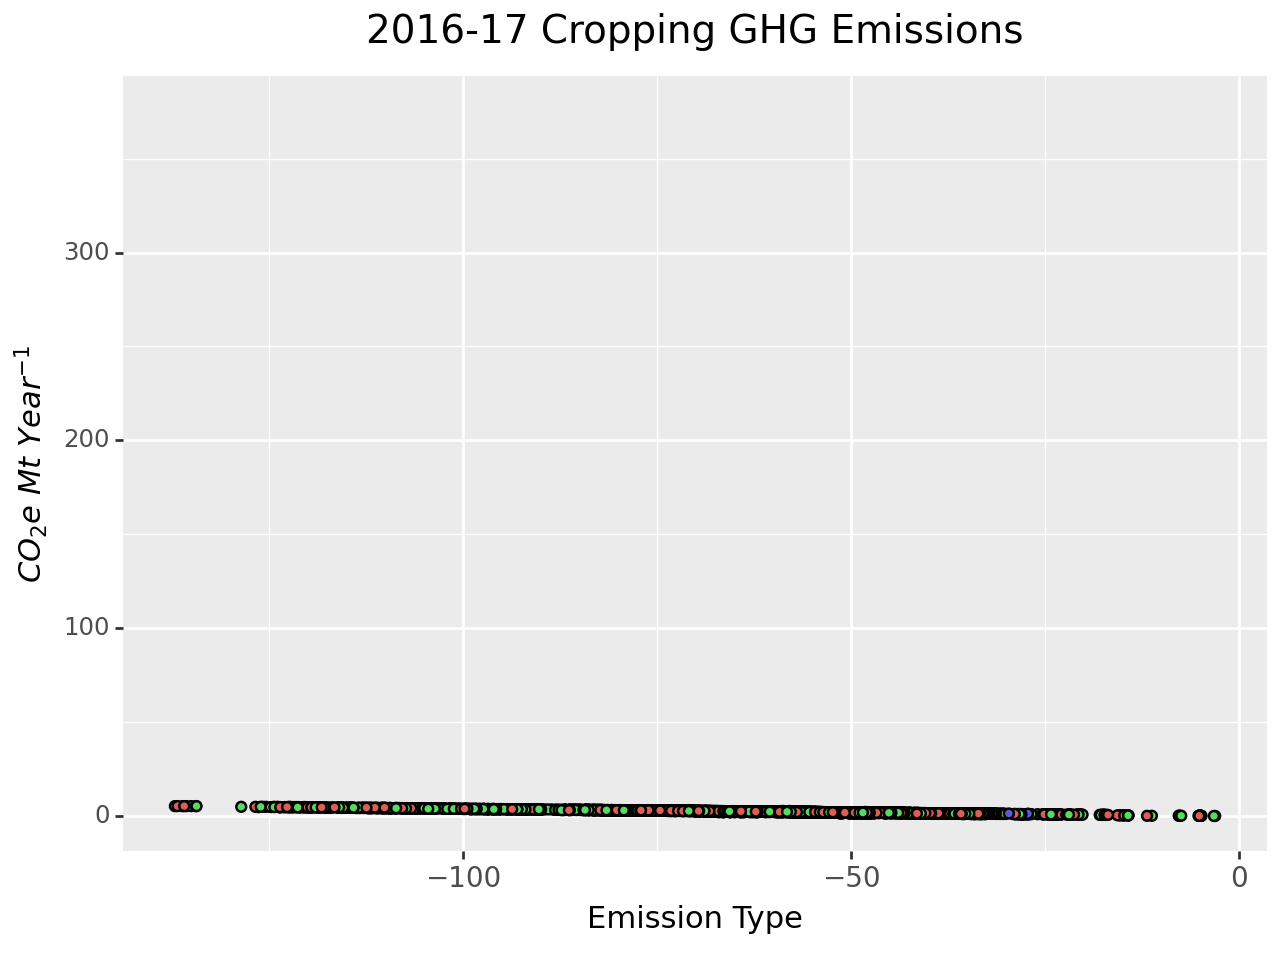

In [616]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$CO_2e\ Mt\ Year^{-1}$")
            # + scale_y_log10()
             +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

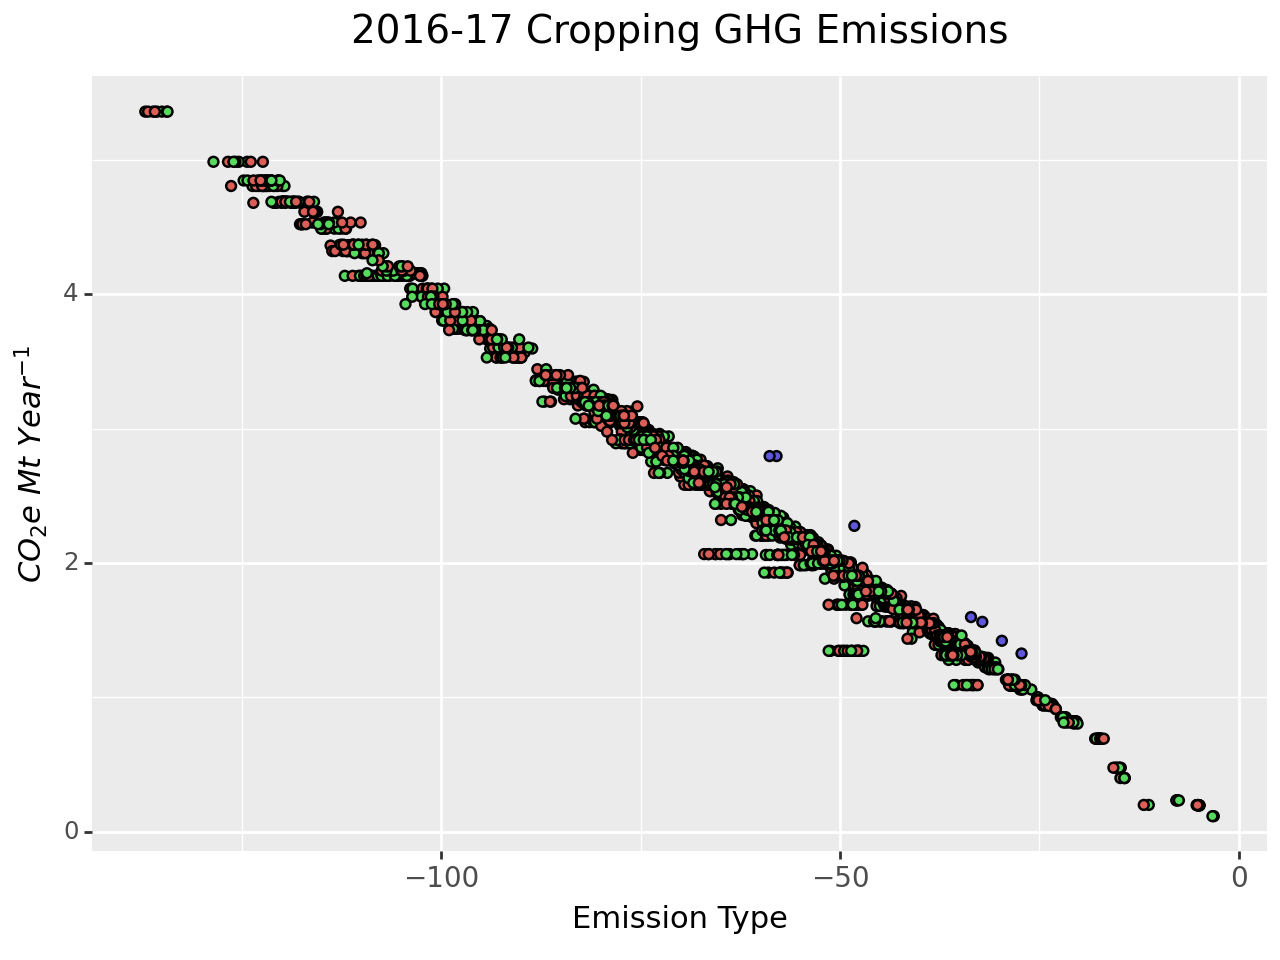

In [617]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$CO_2e\ Mt\ Year^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

In [618]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  geog_checksum apy_crop          crop  \
0 -1106456938604680692    -2140838676     Rice  KHARIF PADDY   
1  2486562343091493142    -2140838676     Rice         PADDY   
2   144395927502297411    -2140838676     Rice         PADDY   
3  8282482022152717920    -2140838676     Rice  KHARIF PADDY   
4  -209892897293663254    -2140838676     Rice  KHARIF PADDY   

              farm_size irrigated  adj_crop_area  adj_fert_area  \
0  MARGINAL (BELOW 1.0)         I     947.490484      33.671078   
1  MARGINAL (BELOW 1.0)         I    2338.048439       0.000000   
2  MARGINAL (BELOW 1.0)        UI    6961.590776    1216.520265   
3  MARGINAL (BELOW 1.0)        UI    3300.374894     408.539286   
4   MEDIUM (4.0 - 9.99)        UI     116.424653       0.508390   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         2.991308       0.283037                      7.935808   
1         2.991308       0.283037                    -75.860959   
2         2.991308       0.283037                     61.553266   
3         2.991308       0.283037                    116.363052   
4         2.991308       0.283037                      5.354141   

   sd_total_n_balance_n_kg_ha  cnt  
0                   26.906571    2  
1                   29.813868    2  
2                   19.812796    2  
3                   27.259266    2  
4                   29.015765    2

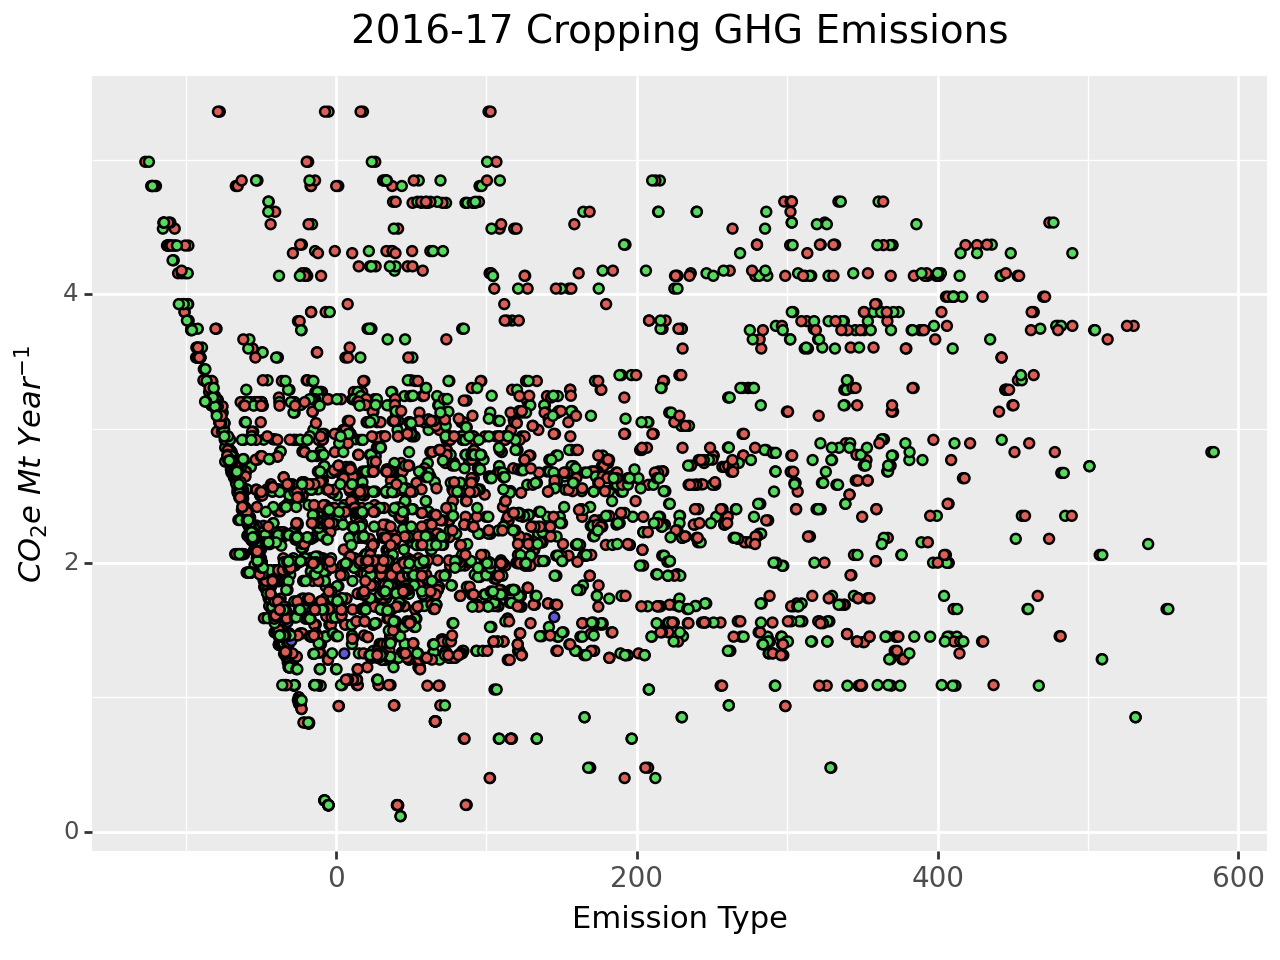

In [619]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$CO_2e\ Mt\ Year^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

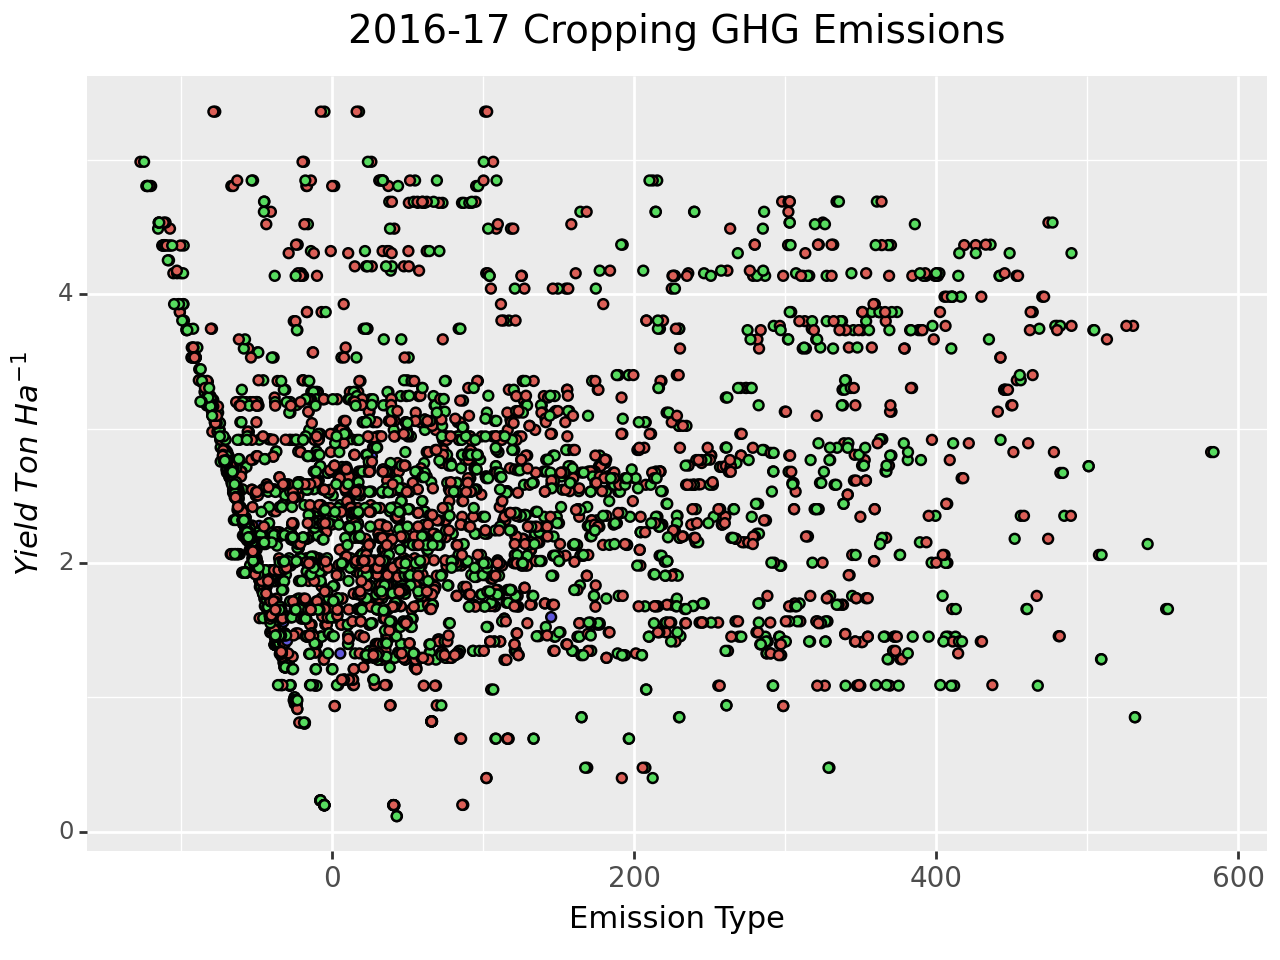

In [620]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

In [621]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
g

SyntaxError: '(' was never closed (<ipython-input-621-c0fd14acd104>, line 2)

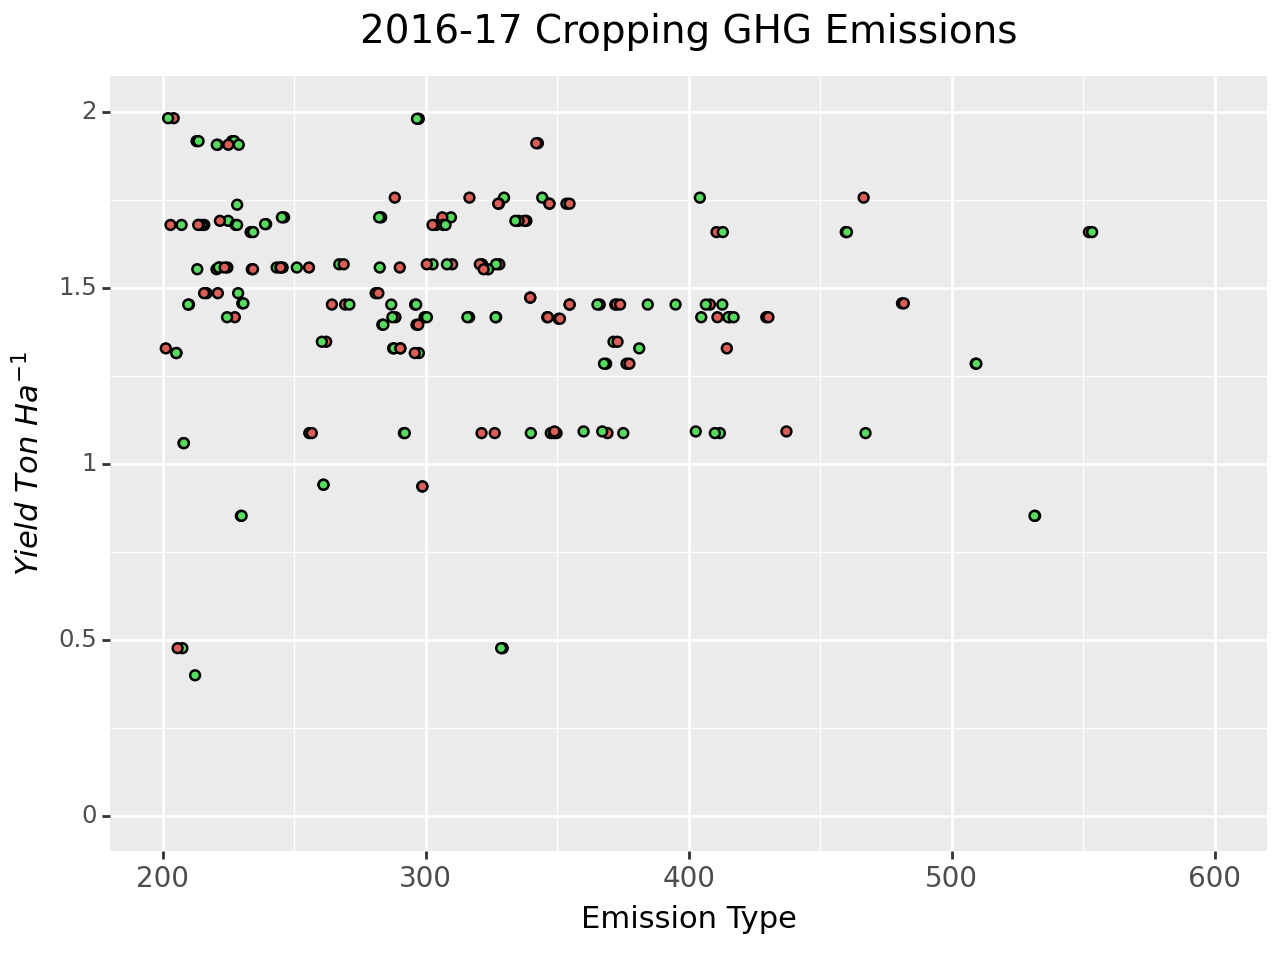

<Figure Size: (640 x 480)>

In [622]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
)
g

In [623]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  rotion_id  geog_checksum apy_crop  \
0 -9222562755093349858          2    -1744491526    Wheat   
1  1850788026111729202          2    -1744491526     Rice   
2  -563242667231640139         34    -1541492885     Rice   
3 -9155122505590433620         34    -1541492885    Wheat   
4 -8656823326947272447         45      384966572     Rice   

              farm_size irrigated  adj_crop_area  adj_fert_area  \
0  LARGE (10 AND ABOVE)         I     417.606323       2.165914   
1  LARGE (10 AND ABOVE)         I     165.663478       0.430149   
2  LARGE (10 AND ABOVE)         I     132.162355       0.197770   
3  LARGE (10 AND ABOVE)         I     268.536914       0.755192   
4    SMALL (1.0 - 1.99)        UI   21289.631336    2093.812909   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         2.758261       0.726251                    141.005690   
1         2.330009       0.368032                     43.398316   
2         2.065804       0.433837                     62.118025   
3         3.097778       0.768498                    151.137497   
4         1.734033       0.387676                    -43.290206   

   sd_total_n_balance_n_kg_ha  rcnt  
0                   17.908808     2  
1                   24.655277     2  
2                   23.161530     2  
3                   19.030496     2  
4                   25.400935     2

In [624]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

PlotnineError: "Could not evaluate the 'fill' mapping: 'crop' (original error: name 'crop' is not defined)"

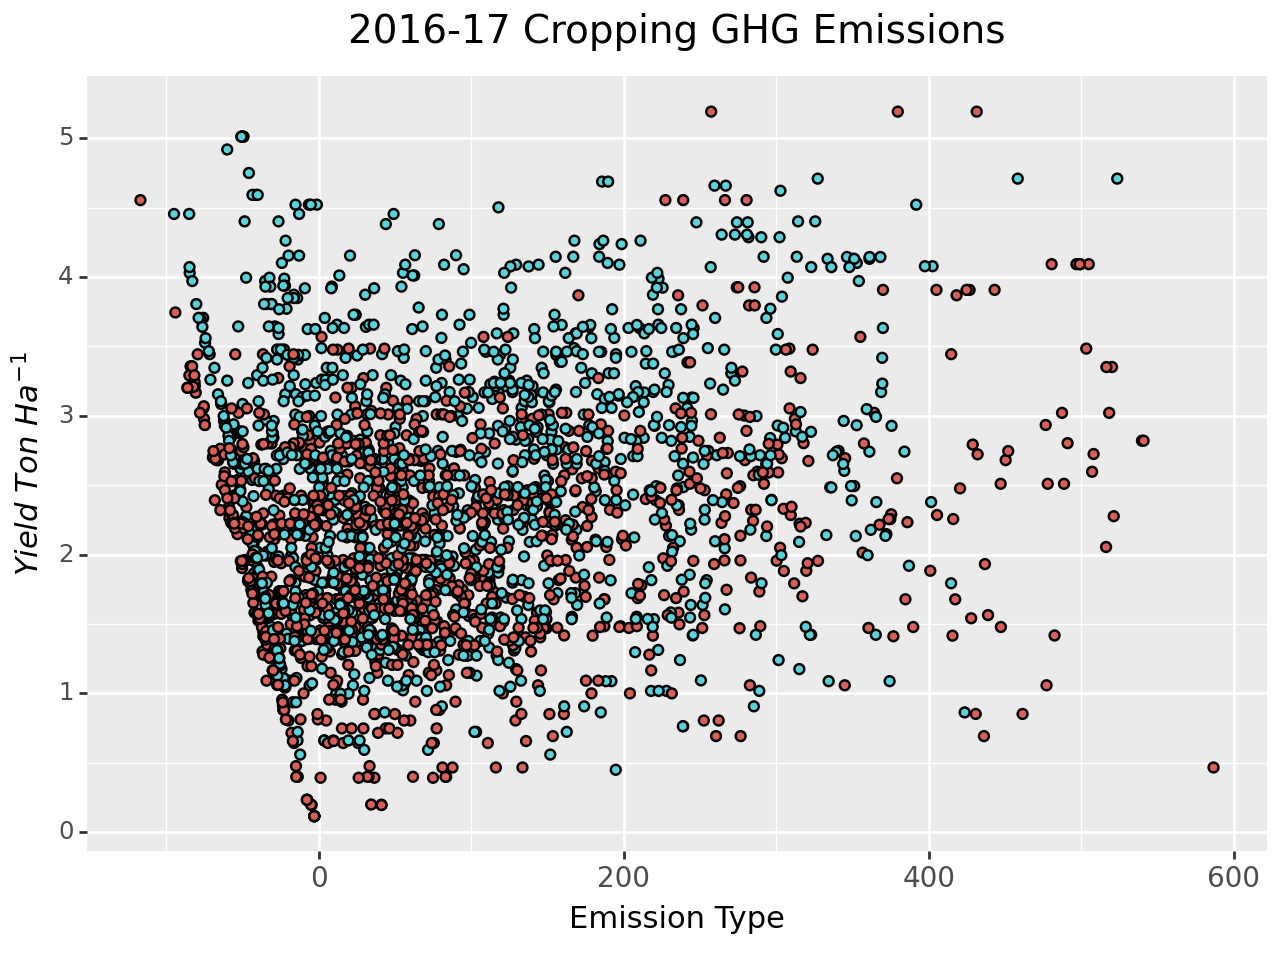

In [625]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='apy_crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            + guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

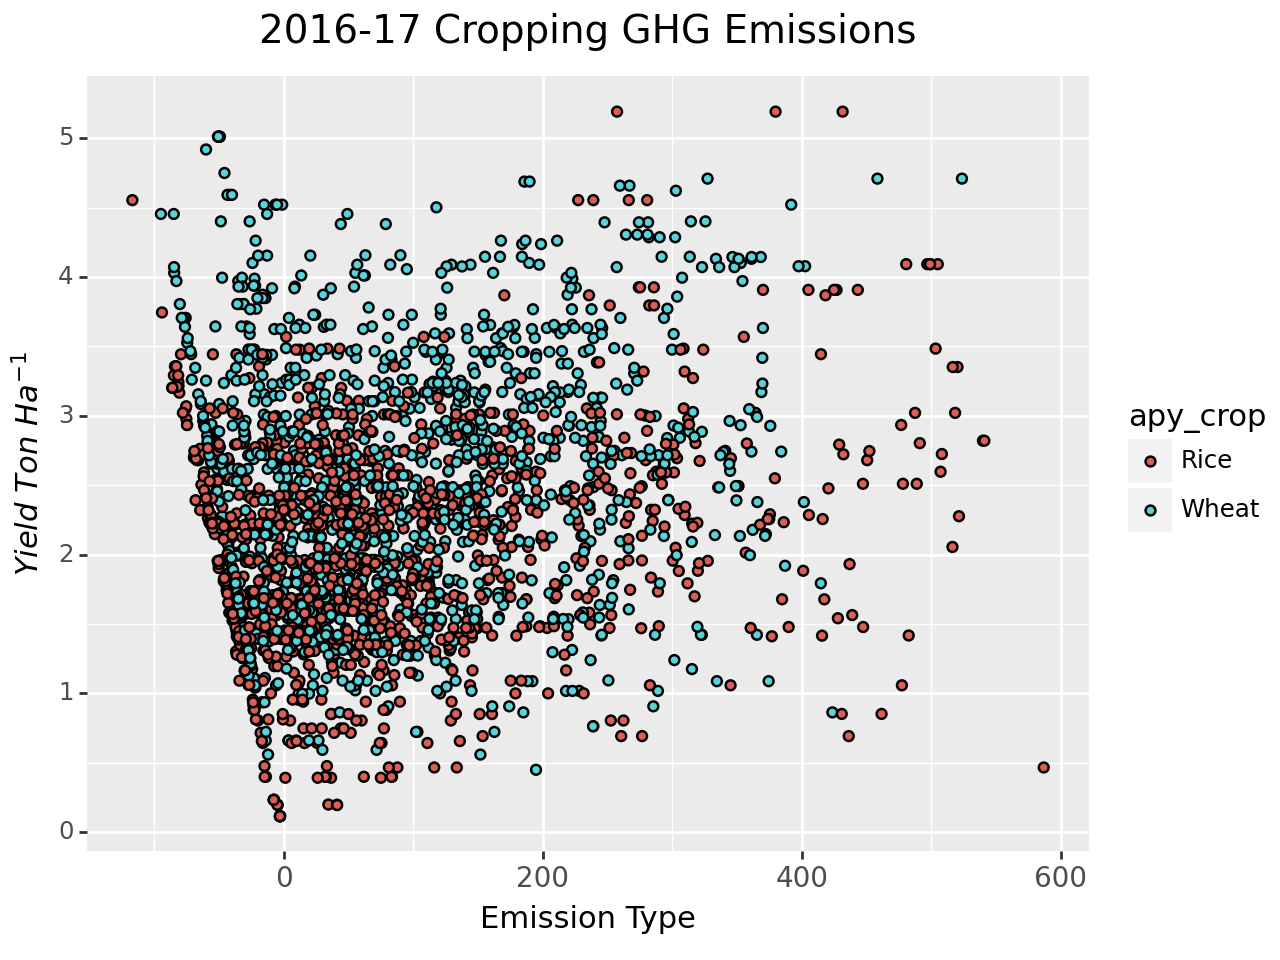

In [626]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='apy_crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            #+ guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

In [627]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotation_id'))
    
)
g

PlotnineError: "Could not evaluate the 'group' mapping: 'rotation_id' (original error: name 'rotation_id' is not defined)"

In [628]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  rotation_id  geog_checksum apy_crop  \
0 -9222562755093349858            2    -1744491526    Wheat   
1  1850788026111729202            2    -1744491526     Rice   
2 -8656823326947272447           45      384966572     Rice   
3 -9105895719958048650           45      384966572    Wheat   
4 -8648288477200863153          209     -955133173    Wheat   

              farm_size irrigated  adj_crop_area  adj_fert_area  \
0  LARGE (10 AND ABOVE)         I     417.606323       2.165914   
1  LARGE (10 AND ABOVE)         I     165.663478       0.430149   
2    SMALL (1.0 - 1.99)        UI   21289.631336    2093.812909   
3    SMALL (1.0 - 1.99)        UI     398.826372      14.592888   
4   MEDIUM (4.0 - 9.99)         I    7606.588838    2642.379950   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         2.758261       0.726251                    141.005690   
1         2.330009       0.368032                     43.398316   
2         1.734033       0.387676                    -43.290206   
3         1.240606       0.099610                    301.543185   
4         1.793915       0.151176                    414.685746   

   sd_total_n_balance_n_kg_ha  rcnt  
0                   17.908808     2  
1                   24.655277     2  
2                   25.400935     2  
3                    4.759961     2  
4                    7.419855     2

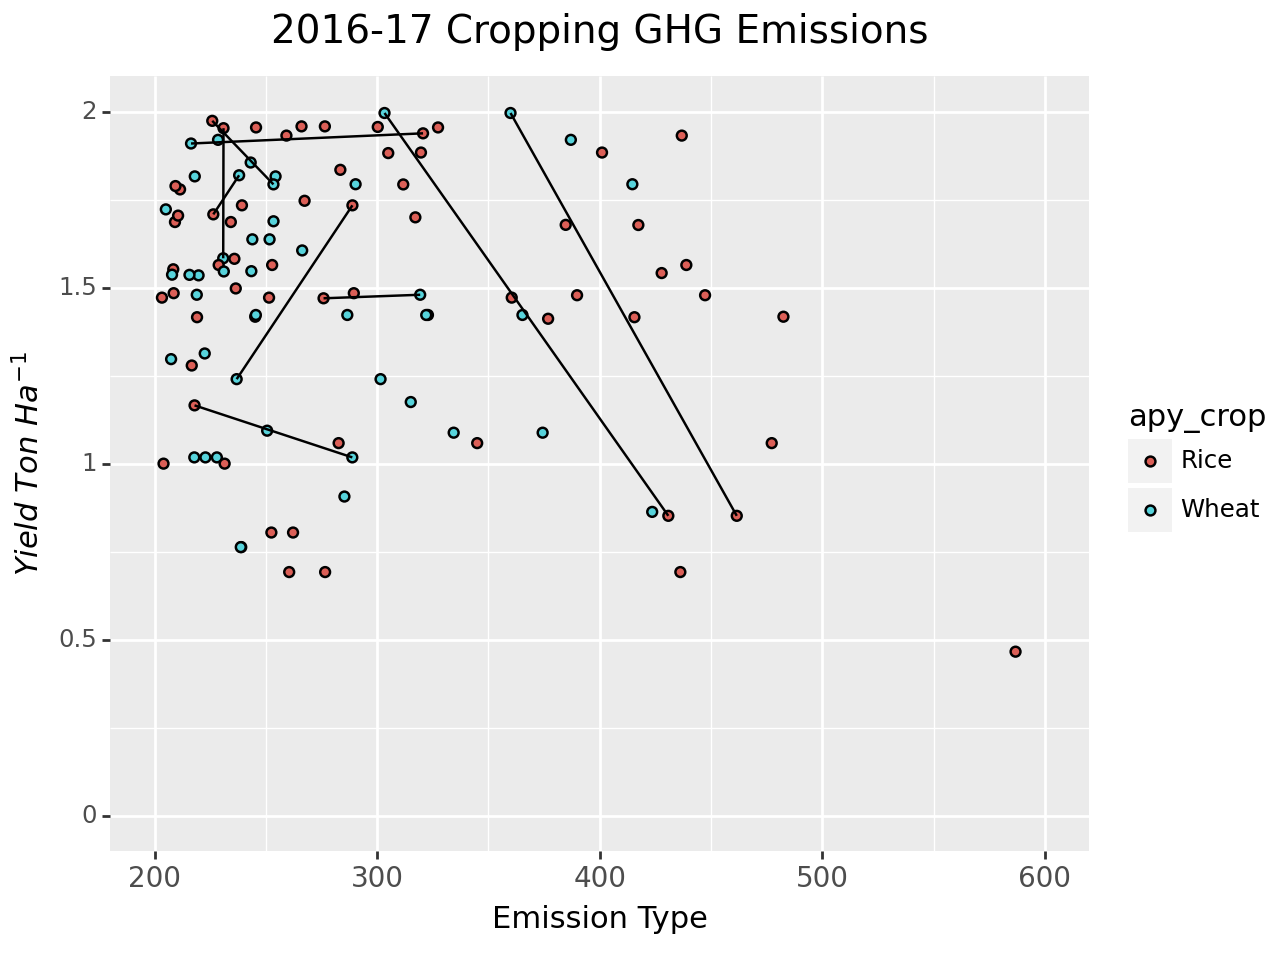

<Figure Size: (640 x 480)>

In [629]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotion_id'))
    
)
g

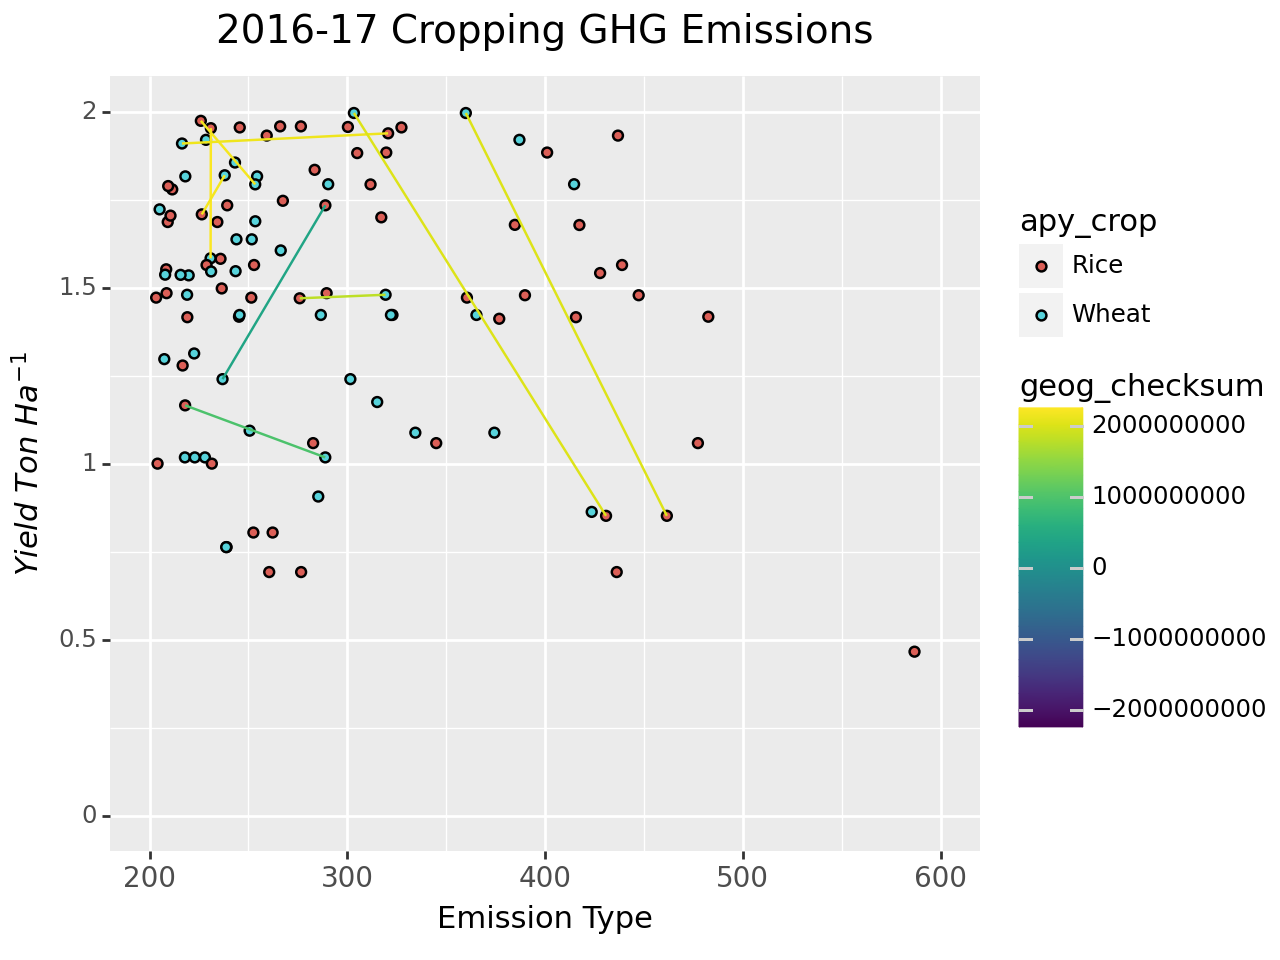

<Figure Size: (640 x 480)>

In [630]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotion_id', color='geog_checksum'))
    
)
g

In [631]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  rotation_id  geog_checksum district_name apy_crop  \
0 -9199181820512947705           15      357371350        Nagpur    Wheat   
1  3449370047825922854           15      357371350        Nagpur     Rice   
2 -4410599054207864306           81      347555406     Balrampur     Rice   
3 -9004552682476483023           81      347555406     Balrampur    Wheat   
4  6274452261296532893          132      869595554         Baksa     Rice   

             farm_size irrigated  adj_crop_area  adj_fert_area  \
0  MEDIUM (4.0 - 9.99)        UI    4337.993248     138.470827   
1  MEDIUM (4.0 - 9.99)        UI   10598.766572     486.282608   
2  MEDIUM (4.0 - 9.99)         I    2191.725359      40.650211   
3  MEDIUM (4.0 - 9.99)         I    2639.491951      78.080308   
4  MEDIUM (4.0 - 9.99)         I     100.491234       0.092258   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         1.546291       0.326366                     34.051985   
1         1.686615       0.396974                     59.146232   
2         2.189557       0.387954                     92.252966   
3         2.887582       0.674336                    312.814988   
4         2.113332       0.208520                    -19.130862   

   sd_total_n_balance_n_kg_ha  rcnt  
0                    9.187210     2  
1                   15.730719     2  
2                   22.393102     2  
3                   17.804685     2  
4                   21.153444     2

In [632]:
rice_wheat_sql = """select  * from vwR_rice_wheat_n_balance"""
rice_wheat_df = load_table_data(db_client_input, rice_wheat_sql)
rice_wheat_df.head()

link_id  rotation_id  geog_checksum district_name apy_crop  \
0 -9104488405158712173           46     -185047221         Satna    Wheat   
1 -1388560231609861715           46     -185047221         Satna     Rice   
2 -7169430335716023404           50     -408108594     Ahmadabad     Rice   
3 -9091671089152679034           50     -408108594     Ahmadabad    Wheat   
4 -8960027005119247885           99    -1997075308       Gurgaon    Wheat   

                  farm_size irrigated  adj_crop_area  adj_fert_area  \
0  SEMI-MEDIUM (2.0 - 3.99)        UI    1859.907307      13.627550   
1  SEMI-MEDIUM (2.0 - 3.99)        UI    9352.266863     521.290604   
2      MARGINAL (BELOW 1.0)         I    3577.751293      86.139460   
3      MARGINAL (BELOW 1.0)         I   10886.698407     812.572517   
4        SMALL (1.0 - 1.99)         I    9225.967984    1773.301776   

   mean_yield_t_ha  sd_yield_t_ha  mean_total_n_balance_n_kg_ha  \
0         3.477715       0.264908                    -22.872359   
1         2.424781       0.497001                    -23.400286   
2         2.371795       0.604151                    534.706764   
3         2.223073       0.235669                      2.220075   
4         4.236842       0.771663                    198.585240   

   sd_total_n_balance_n_kg_ha  rcnt  
0                   13.812915     2  
1                   27.767963     2  
2                   27.403730     2  
3                    9.225387     2  
4                   22.139947     2

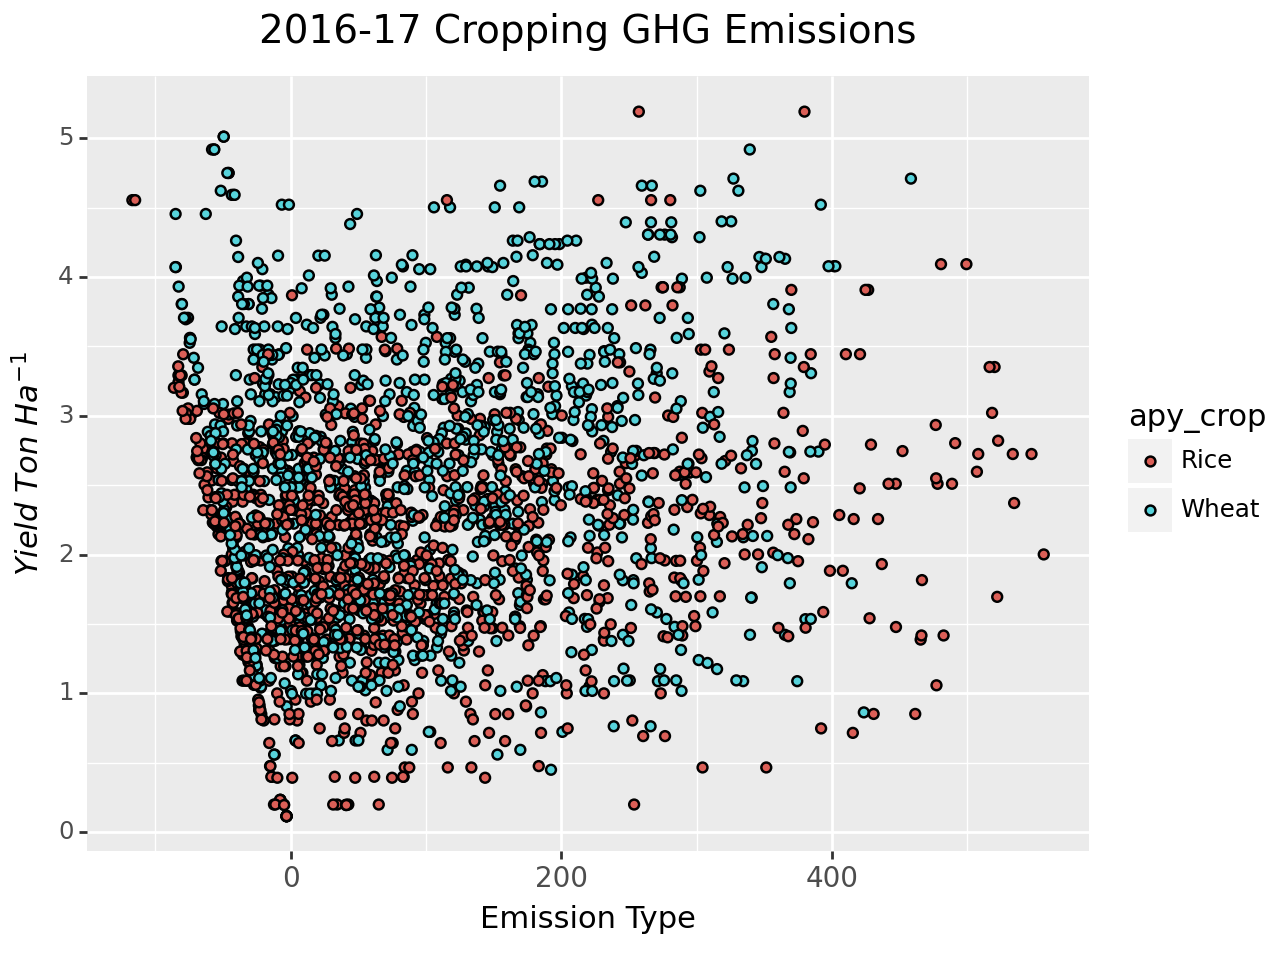

In [633]:
p = (ggplot(rice_wheat_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='apy_crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            #  +scale_y_continuous(limits=(0, 375))
            #+ guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
# p.save(filename=f"national_ghg_15x18.png", path=chart_dir,height=12, width=15, units='cm', dpi=92)

In [634]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotion_id', color='geog_checksum'))
    
)
g

PlotnineError: "Could not evaluate the 'group' mapping: 'rotion_id' (original error: name 'rotion_id' is not defined)"

In [635]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotion_id', color='district_name'))
    
)
g

PlotnineError: "Could not evaluate the 'group' mapping: 'rotion_id' (original error: name 'rotion_id' is not defined)"

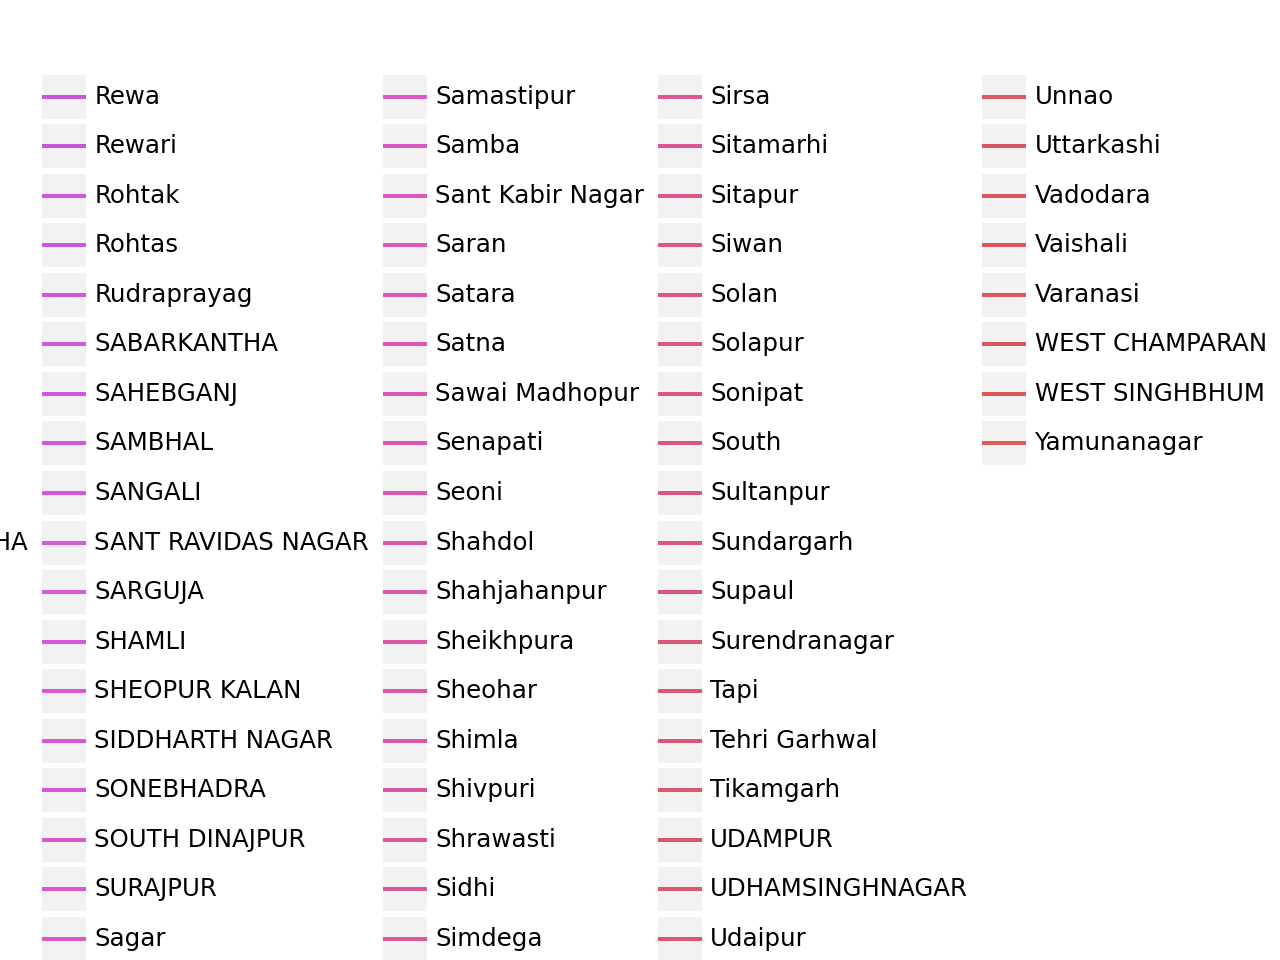

<Figure Size: (640 x 480)>

In [636]:
g = (p + scale_y_continuous(limits=(0, 2))
    + scale_x_continuous(limits=(200, 600))
      + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotation_id', color='district_name'))
    
)
g

In [637]:
filter_df = rice_wheat_df[(rice_wheat_df['mean_total_n_balance_n_kg_ha'] > 200 and rice_wheat_df['mean_yield_t_ha'] < 2)]
p = (ggplot(filter_df)
            # + geom_violin(filter_df,aes(x='dataset', y='kg_inorganic_n_ha'),draw_quantiles=[0.25, 0.5, 0.75])
            + geom_point(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha',fill='apy_crop'))
        #     + geom_errorbar(aes(x='label_simple', ymin='mean_co2e_Mt - sd_co2e_Mt', ymax='mean_co2e_Mt + sd_co2e_Mt'), width=0.2)
        #   + geom_text(aes(x='label_simple', y='mean_co2e_Mt', label='mean_co2e_Mt'), 
        #          va='bottom', ha='center', size=8, format_string='{:.2f}')
    
            # + geom_jitter(filter_df, aes(x='dataset', y='kg_inorganic_n_ha'), color='blue', alpha=.01, size=.001, width=0.3)
             + labs(title='2016-17 Cropping GHG Emissions', x="Emission Type", y="$Yield\ Ton\ Ha^{-1}$")
            # + scale_y_log10()
            + scale_y_continuous(limits=(0, 2))
            + scale_x_continuous(limits=(200, 600))
            + geom_line(aes(x='mean_total_n_balance_n_kg_ha', y='mean_yield_t_ha', group='rotation_id', color='district_name'))
    
            #  +scale_y_continuous(limits=(0, 375))
            #+ guides(fill=None) 
             + theme(axis_text_x=element_text(angle=0, va="top", ha="center", size=10),
             plot_title=element_text(ha='center', size=14))
            # + facet_wrap('~gwp_label')
            )
print(p)
g = (p 
)
g

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().